# Chapter 16 使用RNNs和注意力的自然语言处理

1950年，当 Alan Turing 想象他著名的图灵测试时，他提出了一种方法来评估机器与人类智力相匹配的能力。他本可以测试很多东西，比如在图片中识别猫的能力、下棋、作曲或逃离迷宫，但有趣的是，他选择了一项语言任务。更特殊的是，他设计了一种聊天机器人，能够欺骗对话者，让他们认为自己是人类。这个测试确实有它的弱点：一组硬编码规则可以愚弄欺骗或天真的人类（例如，机器可以给模糊预定义的答案回应一些关键词，它可以假装它是开玩笑或喝醉通过最奇怪的答案，或者它可以逃避难题回答自己的问题），和人类智力的许多方面完全忽略（例如，解释非语言交流的能力，如面部表情，或学习手工任务）。但该测试确实强调了这样一个事实，即掌握语言可以说是智人最大的认知能力。

我们能建立一个能够掌握书面语言和口语的机器吗？这是自然语言处理研究的最终目标，但它有点太宽泛了，所以在实践中，研究人员专注于更具体的任务，如文本分类、翻译、总结、回答问题等等。

自然语言任务的一种常见方法是使用循环神经网络。因此，我们将继续探索 RNNs（在第 15 章中介绍），从 **character RNN** 或 **char-RNN** 开始，训练以预测句子中的下一个字符。这将使我们能够生成一些原始文本。我们将首先使用 **stateless RNN**（它在每次迭代中学习文本的随机部分，没有关于文本其余部分的任何信息），然后我们将构建一个 **stateful RNN**（它在训练迭代之间保留隐藏状态并继续阅读其中的内容，允许它学习更长的模式）。接下来，我们将构建一个 RNN 来执行情感分析（例如，阅读电影评论并提取评分者对电影的感觉），这次将句子视为单词序列，而不是字符。然后我们将展示如何使用 RNNs 构建能够执行 **神经机器翻译（neural machine translation，NMT）** 的编码器-解码器架构，将英语翻译成西班牙语。

在本章的第二部分，我们将探讨 **注意力机制（attention mechanisms）**。顾名思义，这些是神经网络组件，它们学习选择模型其余部分在每个 time step 应该关注的输入部分。首先，我们将使用注意力机制提升基于 RNN 的编码器-解码器架构的性能。接下来，我们将完全放弃 RNN，并使用一种非常成功的 **attention-only 架构**（称为 **transformer**）来构建翻译模型。然后，我们将讨论 NLP 在过去几年中取得的一些最重要的进步，包括非常强大的语言模型，例如 GPT 和 BERT ，它们都基于 Transformer。最后，我将向您展示如何开始使用 Hugging Face 提供的出色的 Transformers 库。

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "nlp"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## 1. 使用 Character RNN 生成莎士比亚式的文本（Generating Shakespearean Text Using a Character RNN）

在 2015 年一篇名为“循环神经网络的不合理有效性”的著名博文中，Andrej Karpathy 展示了如何训练 RNN 来预测句子中的下一个字符。然后这个 char-RNN 可以用来生成新颖的文本，一次一个字符。以下是 char-RNN 模型在接受莎士比亚所有作品的训练后生成的一小部分文本：

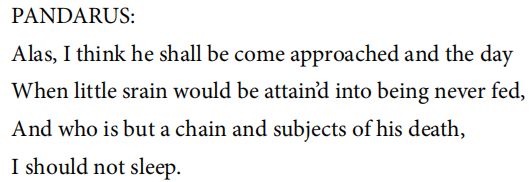

不完全是杰作，但模型能够通过学习预测句子中的下一个字符来学习单词、语法、正确的标点符号等等，这仍然令人印象深刻。这是我们的第一个语言模型示例； 类似（但更强大）的语言模型（将在本章后面讨论）是现代 NLP 的核心。在本节的其余部分，我们将逐步构建一个 char-RNN，从创建数据集开始。

### 1.1 创建训练数据集（Creating the Training Dataset）

首先，使用 Keras 方便的 **tf.keras.utils.get_file()** 函数，让我们下载莎士比亚的所有作品。数据加载自 Andrej Karpathy 的 char-rnn 项目：

In [6]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 [==============================] - 0s 0us/step


让我们打印前几行：

In [7]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


看起来像莎士比亚吧！

接下来，我们将使用 **tf.keras.layers.TextVectorization** 层（在第 13 章中介绍）对该文本进行编码。我们设置 **split="character"** 以获得字符级编码而不是默认的单词级编码，我们使用 **standardize="lower"** 将文本转换为小写（这将简化任务）：

In [8]:
# extra code – shows all 39 distinct characters (after converting to lower case)
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [9]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

现在每个字符都映射到一个整数，从 2 开始。**TextVectorization** 层为填充标记保留了值 0 ，为未知字符保留了 1 。我们现在不需要这些标记中的任何一个，所以让我们从字符 ID 中减去 2 并计算不同字符的数量和字符总数：

In [13]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use

n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39

dataset_size = len(encoded)  # total number of chars = 1,115,394

接下来，就像我们在第 15 章中所做的那样，我们可以将这个非常长的序列转换为一个窗口数据集，然后我们可以使用它来训练一个序列到序列的 RNN 。目标将与输入类似，但向“未来”转移一个时间步长。

例如，数据集中的一个样本可能是表示文本“to be or not to b”（没有最后的“e”）的字符 ID 序列，以及相应的目标——表示文本“o be or not to be”的字符 ID 序列（有最后的“e”，但没有前导的“t”）。

让我们编写一个小实用函数，将一长串字符 ID 转换为输入/目标窗口对的数据集：

In [15]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

这个函数的开始很像我们在第 15 章中创建的 to_windows() 自定义实用函数：
- 它以一个序列作为输入（即编码文本），并创建一个包含所有所需长度窗口的数据集。
- 它将长度增加一个，因为我们需要目标的下一个字符。
- 然后，它会打乱窗口（可选），对它们进行批处理，将它们分成输入/输出对，并激活预取。

下图总结了数据集准备步骤：它显示了长度为 11 的窗口和 3 的批量大小。每个窗口的起始索引在其旁边指示。

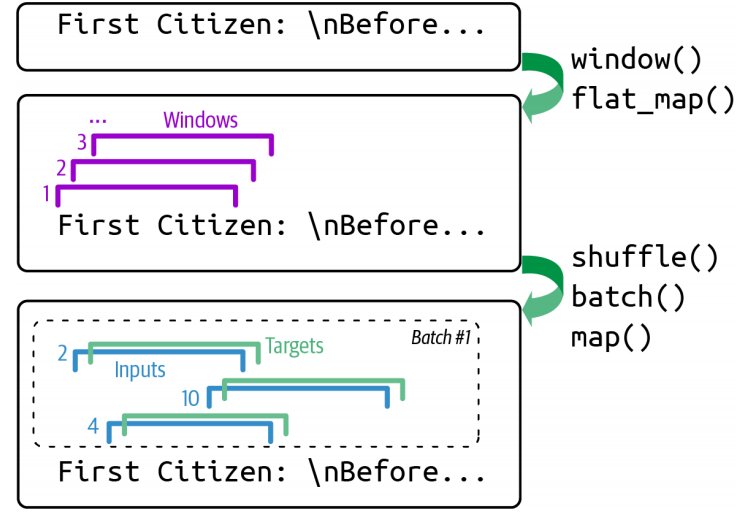

In [16]:
# extra code – a simple example using to_dataset()
# There's just one sample in this dataset: the input represents "to b" and the
# output represents "o be"
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]], dtype=int64)>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]], dtype=int64)>)]

现在我们已准备好创建训练集、验证集和测试集。我们将使用大约 90% 的文本进行训练，5% 用于验证，5% 用于测试：

In [19]:
length = 100

tf.random.set_seed(42)

train_set = to_dataset(encoded[:1_000_000], length=length, 
                       shuffle=True, seed=42)

valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)

test_set = to_dataset(encoded[1_060_000:], length=length)

**注意**：我们将窗口长度设置为100，但你可以尝试调整它：在更短的输入序列上训练 RNN 更容易、更快，但是 RNN 不能学习任何超过 **length** 的模式，所以不要让它太小。

就这样！准备数据集是最困难的部分。现在让我们来创建这个模型。

### 1.2 构建和训练 Char-RNN 模型（Building and Training the Char-RNN Model）

由于我们的数据集相当大，而且建模语言是一项相当困难的任务，所以我们需要的不仅仅是一个简单的 RNN 和一些循环神经元。让我们构建和训练一个由 128 个单元组成的 GRU 层的模型（如果需要，您可以尝试调整层和单元的数量）：

**注意**：以下代码可能需要运行一两个小时，具体取决于您的 GPU。 如果没有 GPU，可能需要 24 小时以上。如果您不想等待，只需跳过接下来的两个代码单元并运行下面的代码即可下载预训练模型。

**注意**：当使用以下参数的默认值时，GRU 类将仅使用 cuDNN 加速（假设您有 GPU）：activation、recurrent_activation、recurrent_dropout、unroll、use_bias 和 reset_after。

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy",
    save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[model_ckpt])

如上代码，

- 我们使用 **Embedding** 层作为第一层，对字符 ID 进行编码（嵌入在第 13 章中介绍过）。**Embedding** 层的输入维度数是不同字符 ID 的数量，输出维度数是一个可以调整的超参数——我们现在将其设置为 16 。**Embedding** 层的输入将是形状为 **\[batch size, window length\]** 的 2D 张量，**Embedding** 层的输出将是形状为 **\[batch size, window length, embedding size\]** 的 3D 张量。
- 我们为输出层使用 **Dense** 层：它必须有 39 个单元 (**n_tokens**)，因为文本中有 39 个不同的字符，我们希望输出每个可能字符的概率（在每个 time step）。39 个输出概率在每个 time step 总和为 1，因此我们将 **softmax** 激活函数应用于 **Dense** 层的输出。
- 最后，我们使用 **"sparse_categorical_crossentropy"** 损失和 **Nadam** 优化器编译该模型，并训练该模型几个 epoch ，使用 **ModelCheckpoint** 回调在训练过程中保存最佳模型（就验证准确性而言）。

**注意**：如果您在激活 GPU 的 Colab 上运行此代码，则训练大约需要一到两个小时。如果你不想等那么久，你可以减少 epoch 的数量，但当然模型的准确性可能会更低。如果 Colab 会话超时，请确保快速重新连接，否则 Colab 运行时将被破坏。

该模型不处理文本预处理，因此让我们将其包装在包含 **tf.keras.layers.TextVectorization** 层作为第一层的最终模型中，加上一个 **tf.keras.layers.Lambda** 层以从字符 ID 中减去 2，因为我们现在不使用填充和未知标记：

In [ ]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

现在让我们用它来预测一个句子中的下一个单词：

In [29]:
# extra code – downloads a pretrained model
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
model_path = Path(path).with_name("shakespeare_model")
shakespeare_model = tf.keras.models.load_model(model_path)

In [32]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 33ms/step


'e'

很好，这个模型正确地预测了下一个单词。现在让我们用这个模型来假装我们是莎士比亚吧！

### 1.3 生成假的莎士比亚式的文本（Generating Fake Shakespearean Text）

要使用 char-RNN 模型生成新文本，我们可以为其提供一些文本，让模型预测最有可能的下一个字母，将其添加到文本的末尾，然后将扩展文本提供给模型以猜测下一个字母，等等。这称为贪心解码。但在实践中，这通常会导致相同的词被一遍又一遍地重复。相反，我们可以使用 TensorFlow 的 **tf.random.categorical()** 函数随机采样下一个字符，概率等于估计概率。这将生成更加多样化和有趣的文本。给定类对数概率 (logits)，**categorical()** 函数对随机类索引进行采样。例如：

In [79]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # probas = 50%, 40%, and 10%

tf.random.set_seed(42)

tf.random.categorical(log_probas, num_samples=8)  # draw 8 samples

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]], dtype=int64)>

为了更好地控制生成文本的多样性，我们可以将 logits 除以一个称为 **temperature** 的数字，我们可以根据需要对其进行调整。接近零的温度有利于高概率字符，而高温则为所有字符提供相同的概率。在生成相当严格和精确的文本（如数学方程式）时通常首选较低的温度，而在生成更多样化和更具创意的文本时首选较高的温度。下面的 **next_char()** 自定义辅助函数使用这种方法来选择下一个要添加到输入文本的字符：

In [80]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

接下来，我们可以编写另一个小的助手函数，它将反复调用 **next_char()** 来获得下一个字符，并将其附加到给定的文本中：

In [81]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

我们现在已经准备好生成一些文本了！让我们尝试使用不同的温度值：

In [82]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

In [83]:
print(extend_text("To be or not to be", temperature=0.01))

1/1 [==============================] - 0s 38ms/step
To be or not to be the duke
as it is a proper strange death,
and the


In [85]:
print(extend_text("To be or not to be", temperature=1))

1/1 [==============================] - 0s 37ms/step
To be or not to beptery;
my vice is my faults while i had rule-maave


In [86]:
print(extend_text("To be or not to be", temperature=100))

1/1 [==============================] - 0s 35ms/step
To be or not to beq'
n?
nms3enpepmtde'
,o :?sdovyqtov!l&b!je?$;hiqte


莎士比亚似乎正遭受着热浪的折磨。为了生成更有说服力的文本，一种常见的技术是仅从前 $k$ 个字符中采样，或者仅从总概率超过某个阈值的最小的前字符集合中采样，这称为 **核采样（nucleus sampling）**。或者，您可以尝试使用 **集束搜索（beam search）**，我们将在本章后面讨论，或者使用更多的 GRU 层和每层更多的神经元，训练更长时间，并在需要时添加一些正则化。

另请注意，该模型目前无法学习长度超过 **length**（仅 100 个字符）的模式。 你可以试着把这个窗口变大，但它也会让训练变得更难，甚至 LSTM 和 GRU 单元也无法处理很长的序列。另一种方法是使用 **有状态 RNN（stateful RNN）** 。

### 1.4 有状态 RNN（Stateful RNN）

到目前为止，我们只使用了无状态 RNN ：在每次训练迭代中，模型从一个全为零的隐藏状态开始，然后在每个 time step 更新这个状态，在最后一个 time step 之后，它把它扔掉，因为它不再被需要了。如果我们指示 RNN 在处理完一个训练批次后保留这个最终状态并将其用作下一个训练批次的初始状态会怎样？通过这种方式，模型可以学习长期模式，尽管仅通过短序列进行反向传播。这称为 **有状态 RNN** 。让我们来看看如何构建一个。

首先，请注意，只有当批次中的每个输入序列恰好从前一批次中相应序列停止的位置开始时，有状态 RNN 才有意义。因此，构建有状态 RNN 需要做的第一件事是使用顺序和非重叠输入序列（而不是我们用来训练无状态 RNN 的打乱和重叠序列）。 因此，在创建 **tf.data.Dataset** 时，我们必须在调用 **window()** 方法时使用 **shift=length**（而不是 shift=1）。 此外，我们不能调用 **shuffle()** 方法。

不幸的是，在为有状态 RNN 准备数据集时，批处理要比为无状态 RNN 准备数据集困难得多。事实上，如果我们要调用 **batch(32)**，那么 32 个连续的窗口将被放入同一个批次中，而下一个批次将不会从它停止的地方继续这些窗口中的每一个。第一批将包含窗口 1 到 32，第二批将包含窗口 33 到 64，因此如果您考虑每批的第一个窗口（即窗口 1 和 33），您可以看到它们不是连续的。这个问题最简单的解决方案是只使用 1 的批量大小。以下 **to_dataset_for_stateful_rnn()** 自定义实用程序函数使用此策略为有状态 RNN 准备数据集：

In [87]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)

stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000], length)

stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

下图总结了该函数的主要步骤：

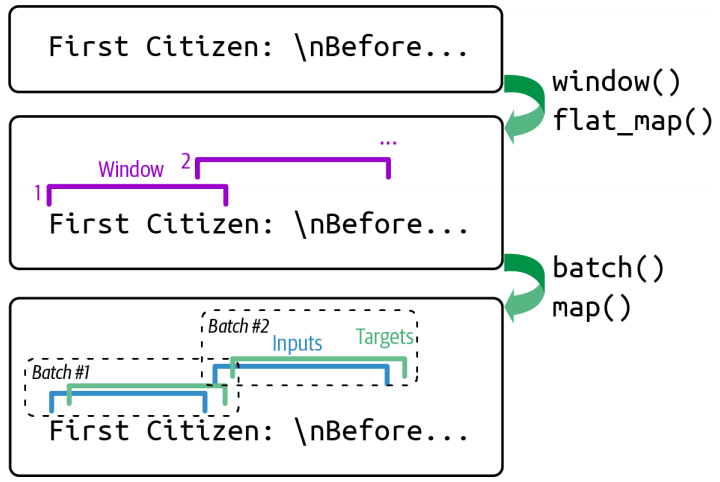

批处理更难，但并非不可能。

例如，我们可以将莎士比亚的文本分成 32 个等长的文本，为每个文本创建一个连续输入序列的数据集，最后使用 **tf.data.Dataset.zip(datasets).map(lambda \*windows: tf.stack (windows))** 以创建适当的连续批次，其中批次中的第 $n$ 个输入序列恰好从前一批次中第 $n$ 个输入序列结束的位置开始。

In [89]:
# extra code – simple example using to_dataset_for_stateful_rnn()
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]])>)]

如果你想每批有多个窗口，你可以使用 **to_batched_dataset_for_stateful_rnn()** 函数而不是 **to_dataset_for_stateful_rnn()** ：

In [90]:
# extra code – shows one way to prepare a batched dataset for a stateful RNN

import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]])>)]

现在，让我们创建有状态的 RNN。我们需要在创建每个循环层时将 **stateful** 参数设置为 True，因为有状态 RNN 需要知道批量大小（因为它将为批量中的每个输入序列保留一个状态）。因此我们必须在第一层设置 **batch_input_shape** 参数。请注意，我们可以不指定第二个维度，因为输入序列可以具有任意长度：

In [91]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

在每个 epoch 结束时，我们需要在返回文本开头之前重置状态。为此，我们可以使用一个小的自定义 Keras 回调：

In [92]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

现在我们可以编译这个模型，并使用我们的回调来训练它：

In [93]:
# extra code – use a different directory to save the checkpoints
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

In [94]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=10, callbacks=[ResetStatesCallback(), model_ckpt])

Epoch 1/10
   9999/Unknown - 109s 11ms/step - loss: 1.8709 - accuracy: 0.4488

INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


9999/9999 [==============================] - 119s 12ms/step - loss: 1.8709 - accuracy: 0.4488 - val_loss: 1.7075 - val_accuracy: 0.4896
Epoch 2/10
9995/9999 [============================>.] - ETA: 0s - loss: 1.5670 - accuracy: 0.5273

INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


9999/9999 [==============================] - 116s 12ms/step - loss: 1.5669 - accuracy: 0.5274 - val_loss: 1.6275 - val_accuracy: 0.5101
Epoch 3/10
9998/9999 [============================>.] - ETA: 0s - loss: 1.4905 - accuracy: 0.5471

INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


9999/9999 [==============================] - 115s 12ms/step - loss: 1.4905 - accuracy: 0.5471 - val_loss: 1.5900 - val_accuracy: 0.5217
Epoch 4/10
9999/9999 [==============================] - ETA: 0s - loss: 1.4518 - accuracy: 0.5571

INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


9999/9999 [==============================] - 115s 12ms/step - loss: 1.4518 - accuracy: 0.5571 - val_loss: 1.5729 - val_accuracy: 0.5267
Epoch 5/10
9995/9999 [============================>.] - ETA: 0s - loss: 1.4277 - accuracy: 0.5630

INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


9999/9999 [==============================] - 116s 12ms/step - loss: 1.4276 - accuracy: 0.5630 - val_loss: 1.5617 - val_accuracy: 0.5311
Epoch 6/10
9999/9999 [==============================] - 110s 11ms/step - loss: 1.4108 - accuracy: 0.5674 - val_loss: 1.5529 - val_accuracy: 0.5309
Epoch 7/10
9995/9999 [============================>.] - ETA: 0s - loss: 1.3986 - accuracy: 0.5701

INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


9999/9999 [==============================] - 116s 12ms/step - loss: 1.3986 - accuracy: 0.5701 - val_loss: 1.5447 - val_accuracy: 0.5349
Epoch 8/10
9995/9999 [============================>.] - ETA: 0s - loss: 1.3896 - accuracy: 0.5723

INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


9999/9999 [==============================] - 114s 11ms/step - loss: 1.3896 - accuracy: 0.5723 - val_loss: 1.5388 - val_accuracy: 0.5365
Epoch 9/10
9999/9999 [==============================] - 108s 11ms/step - loss: 1.3827 - accuracy: 0.5743 - val_loss: 1.5371 - val_accuracy: 0.5363
Epoch 10/10
9999/9999 [==============================] - 108s 11ms/step - loss: 1.3777 - accuracy: 0.5760 - val_loss: 1.5316 - val_accuracy: 0.5359


**注意**：在这个模型经过训练后，它将只能使用它来对与在训练过程中使用的相同大小的批次进行预测。为了避免此限制，请创建一个相同的无状态模型，并将有状态模型的权重复制到此模型中。

In [95]:
# To use the model with different batch sizes, we need to create a stateless copy

stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [96]:
# To set the weights, we first need to build the model (so the weights get created)

stateless_model.build(tf.TensorShape([None, None]))

In [97]:
stateless_model.set_weights(model.get_weights())

In [98]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    stateless_model
])

In [99]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=0.01))

1/1 [==============================] - 0s 34ms/step
to be or not to be good for her bears,
and i will not to her for him


有趣的是，虽然 char-RNN 模型只是被训练来预测下一个字符，但这个看似简单的任务实际上还需要它学习一些更高级别的任务。例如，要查找“Great movie, I really”之后的下一个字符，这有助于理解句子是肯定的，因此后面更可能是字母“l”（表示“loved”）而不是“h”（表示“hated”）。事实上，Alec Radford 和其他 OpenAI 研究人员在 2017 年发表的一篇论文描述了作者如何在大型数据集上训练大型 char-RNN 类模型，并发现其中一个神经元充当了出色的情感分析分类器：尽管该模型是在没有任何标签的情况下训练，情绪神经元在情绪分析基准上达到了最先进的性能。这预示并激发了 NLP 中的无监督预训练。

但在我们探索无监督预训练之前，让我们将注意力转向词级模型以及如何以监督方式使用它们进行情感分析。在此过程中，您将学习如何使用掩码处理可变长度的序列。

## 2.  情感分析（Sentiment Analysis）

生成文本既有趣又有启发性，但在现实生活中，NLP 最常见的应用之一是文本分类——尤其是情感分析。如果 MNIST 数据集上的图像分类是计算机视觉的“Hello world!”，则对 IMDb 评论数据集的情感分析是自然语言处理的“Hello world!”。IMDb 数据集包含从著名的互联网电影数据库中提取的 50,000 条英文电影评论（25,000 条用于训练，25,000 条用于测试），以及每个评论的简单二元目标，指示它是负面的 (0) 还是正面的 (1)。就像 MNIST 一样，IMDb 评论数据集很受欢迎有充分的理由：它足够简单，可以在合理的时间内在笔记本电脑上解决，但又足够具有挑战性，既有趣又有益。

让我们使用 TensorFlow Datasets 库（在第 13 章中介绍）加载 IMDb 数据集。 我们将使用前 90% 的训练集进行训练，剩下的 10% 用于验证：

In [6]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)

train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)

valid_set = raw_valid_set.batch(32).prefetch(1)

test_set = raw_test_set.batch(32).prefetch(1)

**注意**：Keras 还包括一个用于加载 IMDb 数据集的函数，如果您喜欢的话：**tf.keras.datasets.imdb.load_data()** 。这些评论已经被预处理为单词 ID 的序列。

让我们来看看一些评论：

In [7]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8")[:200], "...")
    print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
Label: 0
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
Label: 1


有些评论很容易分类。例如，第一条评论在第一句话中包含“terrible movie”一词。但在很多情况下，事情并没有那么简单。例如，第三条评论一开始是正面的，尽管它最终是负面评论（label 0）。

要为此任务构建模型，我们需要对文本进行预处理，但这次我们会将其切成单词而不是字符。为此，我们可以再次使用 **tf.keras.layers.TextVectorization** 层。请注意，它使用空格来标识单词边界，这在某些语言中效果不佳。例如，中文写作在单词之间不使用空格，越南语甚至在单词内部也使用空格，而德语经常将多个单词连接在一起，而不使用空格。即使在英语中，空格也不总是标记文本的最佳方式：想想“San Francisco”或“#ILoveDeepLearning”。

幸运的是，有一些解决方案可以解决这些问题。在 2016 年的一篇论文中，Rico Sennrich 等人，来自爱丁堡大学的研究人员探索了几种在子词级别对文本进行标记化和去标记化的方法。这样，即使你的模型遇到了它以前见过的生僻词，它仍然可以合理地猜出它的意思。例如，即使模型在训练过程中从未见过“smartest”这个词，如果它学会了“smart”这个词，并且还学会了后缀“est”的意思是“最”，它就可以推断出“最聪明”的意思。作者评估的技术之一是 **字节对编码（byte pair encoding，BPE）**。BPE 的工作原理是将整个训练集拆分为单个字符（包括空格），然后反复合并最频繁的相邻对，直到词汇量达到所需的大小。

谷歌 Taku Kudo 于 2018 年发表的一篇论文进一步改进了子词标记化，通常消除了在标记化之前对特定语言进行预处理的需要。此外，该论文提出了一种称为 **子词正则化（subword regularization）** 的新型正则化技术，它通过在训练过程中引入一些随机性来提高准确性和鲁棒性：例如，“New England”可能被标记为“New”+“England”或“New” + “Eng” + “land”，或简称“New England”（仅一个标记）。Google 的 SentencePiece 项目提供了一个开源实现，Taku Kudo 和 John Richardson 在一篇论文中对此进行了描述。

TensorFlow Text 库还实现了各种标记化策略，包括 WordPiece（ BPE 的一种变体），最后并且重要是，Hugging Face 的 Tokenizers 库实现了范围广泛的极快标记器。

但是，对于英文的 IMDb 任务，使用空格作为标记边界应该就足够了。因此，让我们继续创建一个 **TextVectorization** 层并使其拟合训练集。我们将词汇量限制为 1000 个标记，包括最常见的 998 个单词加上一个填充标记和一个未知单词标记，因为非常罕见的单词不太可能对这项任务很重要，限制词汇量会减少模型需要学习的参数：

In [8]:
vocab_size = 1000

text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)

text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

最后，我们可以创建模型并训练它：

**注意**：以下单元将需要几分钟才能运行，模型可能不会学习任何东西，因为我们没有屏蔽填充标记（这是下一节的重点）。

In [9]:
embed_size = 128

tf.random.set_seed(42)

model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 41s 52ms/step - loss: 0.6934 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 2/2
704/704 [==============================] - 35s 50ms/step - loss: 0.6928 - accuracy: 0.5043 - val_loss: 0.6974 - val_accuracy: 0.4996


第一层是我们刚刚准备的 **TextVectorization** 层，然后是将单词 ID 转换为嵌入的 **Embedding** 层。嵌入矩阵需要在 vocabulary(vocab_size) 中每个 token 一行，每个嵌入维度一列（此示例使用 128 个维度，但这是您可以调整的超参数）。接下来我们使用一个 **GRU** 层和一个具有单个神经元和 sigmoid 激活函数的 **Dense** 层，因为这是一个二元分类任务：模型的输出将是评论表达对电影的积极情绪的估计概率。然后我们编译模型，并将其拟合到我们之前为几个 epoch 准备的数据集上（或者您可以训练更长时间以获得更好的结果）。

不幸的是，如果你运行这段代码，你通常会发现模型根本无法学习任何东西：准确率仍然接近 50%，并不比随机概率好多少。这是为什么？评论有不同的长度，因此当 **TextVectorization** 层将它们转换为 token ID 序列时，它使用填充 token（ID 为 0）填充较短的序列，使它们与批处理中最长的序列一样长。因此，大多数序列以许多填充 token 结尾——通常是几十个甚至数百个。尽管我们使用的是 **GRU** 层，它比 **SimpleRNN** 层好得多，但它的短期记忆仍然不是很好，所以当它经过许多填充 token 时，它最终会忘记评论的内容！一种解决方案是为模型提供多批等长句子（这也可以加快训练速度）。另一种解决方案是让 RNN 忽略填充标记。这可以使用 **掩码（masking）** 来完成。

### 2.1 掩码（Masking）

使用 Keras 让模型忽略填充 token 很简单：只需在创建 **Embedding** 层时添加 **mask_zero=True** 即可。这意味着填充 token（其 ID 为 0）将被所有下游层忽略。就这样！如果将之前的模型重新训练几个 epoch ，你会发现验证准确率很快达到80%以上。

In [107]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 43s 54ms/step - loss: 0.6549 - accuracy: 0.6298 - val_loss: 0.5529 - val_accuracy: 0.7172
Epoch 2/5
704/704 [==============================] - 36s 51ms/step - loss: 0.4205 - accuracy: 0.8143 - val_loss: 0.3713 - val_accuracy: 0.8436
Epoch 3/5
704/704 [==============================] - 36s 51ms/step - loss: 0.3511 - accuracy: 0.8528 - val_loss: 0.3407 - val_accuracy: 0.8608
Epoch 4/5
704/704 [==============================] - 36s 51ms/step - loss: 0.3102 - accuracy: 0.8717 - val_loss: 0.3156 - val_accuracy: 0.8680
Epoch 5/5
704/704 [==============================] - 36s 51ms/step - loss: 0.2768 - accuracy: 0.8892 - val_loss: 0.3223 - val_accuracy: 0.8664


其工作方式是 **Embedding** 层创建一个等于 **tf.math.not_equal(inputs, 0)** 的 **掩码张量（mask tensor）**：它是一个与输入具有相同形状的布尔张量，并且在 token ID 为 0 所在的任何地方都等于 False，否则为 True。这个掩码张量然后由模型自动传播到下一层。如果该层的 **call()** 方法有一个 **mask** 参数，那么它会自动接收掩码。这允许该层忽略适当的 time step。每个层可能会以不同方式处理掩码，但通常它们会简单地忽略掩码 time step（即掩码为 False 的时间步长）。例如，当循环层遇到屏蔽 time step 时，它只是简单地复制前一个 time step 的输出。

接下来，如果该层的 **supports_masking** 属性为 **True**，则掩码会自动传播到下一层。只要层具有 **supports_masking=True**，它就会一直以这种方式传播。例如，循环层的 **supports_masking** 属性在 **return_sequences=True** 时为 **True**，但在 **return_sequences=False** 时为 **False**，因为在这种情况下不再需要掩码。因此，如果您的模型有多个 **return_sequences=True** 的循环层，后面跟着一个 **return_sequences=False** 的循环层，那么掩码将自动传播到最后一个循环层：该层将使用掩码忽略 masked steps，但是它不会进一步传播掩码。同样，如果在我们刚刚构建的情感分析模型中创建 **Embedding** 层时设置 **mask_zero=True**，那么 **GRU** 层将自动接收并使用掩码，但不会进一步传播它，因为 **return_sequences** 未设置为 **True** 。

**注意**：有些层需要在将掩码传播到下一层之前更新掩码：它们通过实现 **compute_mask()** 方法来实现，该方法有两个参数：输入和前一个掩码。然后它计算更新后的掩码并将其返回。**compute_mask()** 的默认实现只是返回前一个掩码不变。

许多 Keras 层都支持掩码：**SimpleRNN**、**GRU**、**LSTM**、**Bidirectional**、**Dense**、**TimeDistributed**、**Add** 和其他一些层（都在 **tf.keras.layers** 包中）。然而，卷积层（包括 **Conv1D**）不支持掩码——无论会怎么做并不明显。

如果掩码一直传播到输出，那么它也会应用于损失，因此 masked time step 不会对损失产生影响（它们的损失将为 0）。这假设模型输出序列，而在我们的情绪分析模型中并非如此。

**注意**：**LSTM** 和 **GRU** 层基于 Nvidia 的 cuDNN 库针对 GPU 进行了优化实现。但是，此实现仅在所有填充 token 都位于序列末尾时才支持掩码。它还要求您使用几个超参数的默认值：**activation**、**recurrent_activation**、**recurrent_dropout**、**unroll**、**use_bias** 和 **reset_after**。如果不是这种情况，那么这些层将回退到（慢得多的）默认 GPU 实现。

如果你想实现你自己的带有掩码支持的自定义层，你应该向 **call()** 方法添加一个 **mask** 参数，并且显式地让该方法使用掩码。此外，如果必须将掩码传播到下一层，则应在构造函数中设置 **self.supports_masking=True**。如果必须在传播之前更新掩码，则必须实施 **compute_mask()** 方法。

如果您的模型不是从 **Embedding** 层开始的，您可以改用 **tf.keras.layers.Masking** 层：默认情况下，它将掩码设置为 **tf.math.reduce_any(tf.math.not_equal(X, 0), axis=-1)** ，这意味着最后一个维度充满零的 time step 将在后续层中被屏蔽掉。

使用掩码层和自动掩码传播最适合简单模型。它并不总是适用于更复杂的模型，例如当您需要将 **Conv1D** 层与循环层混合时。在这种情况下，您将需要使用 **函数式 API** 或 **子类化 API** 显式计算掩码并将其传递到适当的层。例如，以下模型等同于之前的模型，只是它是使用 **函数式 API** 构建的并手动处理掩码。它还增加了一些 dropout ，因为之前的模型略微过拟合：

In [108]:
# using manual masking

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

token_ids = text_vec_layer(inputs)

mask = tf.math.not_equal(token_ids, 0)

Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)

Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [109]:
# extra code – compiles and trains the model, as usual
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 42s 53ms/step - loss: 0.5065 - accuracy: 0.7467 - val_loss: 0.4500 - val_accuracy: 0.8108
Epoch 2/5
704/704 [==============================] - 36s 52ms/step - loss: 0.3374 - accuracy: 0.8586 - val_loss: 0.3116 - val_accuracy: 0.8724
Epoch 3/5
704/704 [==============================] - 37s 52ms/step - loss: 0.2879 - accuracy: 0.8823 - val_loss: 0.3149 - val_accuracy: 0.8644
Epoch 4/5
704/704 [==============================] - 37s 52ms/step - loss: 0.2678 - accuracy: 0.8901 - val_loss: 0.3067 - val_accuracy: 0.8692
Epoch 5/5
704/704 [==============================] - 36s 52ms/step - loss: 0.2530 - accuracy: 0.8967 - val_loss: 0.3440 - val_accuracy: 0.8508


最后一种掩码方法是为模型提供参差不齐的张量。实际上，您需要做的就是在创建 **TextVectorization** 层时设置 **ragged=True**，以便输入序列表示为参差不齐的张量：

In [110]:
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, ragged=True)

text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))

text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

<tf.RaggedTensor [[86, 18], [11, 7, 1, 116, 217]]>

将这个参差不齐的张量表示与使用填充 token 的常规张量表示进行比较：

In [112]:
text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  18,   0,   0,   0],
       [ 11,   7,   1, 116, 217]], dtype=int64)>

In [113]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer_ragged,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5


C:\Users\tu'tu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_5/gru_5/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_5/gru_5/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_5/gru_5/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


704/704 [==============================] - 41s 55ms/step - loss: 0.5469 - accuracy: 0.7293 - val_loss: 0.4709 - val_accuracy: 0.7740
Epoch 2/5
704/704 [==============================] - 38s 53ms/step - loss: 0.3429 - accuracy: 0.8514 - val_loss: 0.3199 - val_accuracy: 0.8580
Epoch 3/5
704/704 [==============================] - 38s 53ms/step - loss: 0.2928 - accuracy: 0.8768 - val_loss: 0.3678 - val_accuracy: 0.8360
Epoch 4/5
704/704 [==============================] - 38s 54ms/step - loss: 0.2708 - accuracy: 0.8882 - val_loss: 0.3371 - val_accuracy: 0.8528
Epoch 5/5
704/704 [==============================] - 38s 54ms/step - loss: 0.2568 - accuracy: 0.8944 - val_loss: 0.3291 - val_accuracy: 0.8540


Keras 的循环层内置了对参差不齐的张量的支持，因此您无需执行任何其他操作：只需在您的模型中使用此 **TextVectorization** 层即可。无需传递 **mask_zero=True** 或显式处理掩码——它们都已为您实现。那很方便！然而，截至 2022 年初，Keras 对参差不齐的张量的支持还是相当新的，因此存在一些粗糙的问题。例如，当前无法在 GPU 上运行时使用参差不齐的张量作为目标（但这可能会在您阅读这些行时解决）。

无论你喜欢哪种掩码方法，在训练这个模型几个 epoch 之后，它会变得非常擅长判断评论是正面的还是负面的。如果您使用 tf.keras.callbacks.TensorBoard() 回调，您可以在学习 TensorBoard 时可视化嵌入：看到像“awesome”和“amazing”这样的词逐渐聚集在嵌入空间的一侧是很有趣的，而像“awful”和“terrible”这样的词则聚集在另一边。有些词并不像你预期的那样积极（至少对于这个模型），比如“good”这个词，大概是因为许多负面评论包含“not good”这个短语。

### 2.2 重用预训练的嵌入和语言模型（Reusing Pretrained Embeddings and Language Models）

令人印象深刻的是，该模型仅基于 25000 条电影评论就能够学习有用的词嵌入。 想象一下，如果我们有数十亿条评论可供训练，嵌入会有多好！不幸的是，我们没有，但也许我们可以重用在其他（非常）大的文本语料库（例如，亚马逊评论，可在 TensorFlow 数据集上获得）上训练的词嵌入，即使它不是由电影评论组成？毕竟，无论你用它来谈论电影还是其他任何事情，“amazing”这个词通常具有相同的含义。此外，即使嵌入在另一项任务上接受训练，它们也可能对情感分析有用：因为像“awesome”和“amazing”这样的词具有相似的含义，即使对于预测一句话中的下一个单词任务等任务，它们也可能聚集在嵌入空间中。如果所有正面词和所有负面词都形成聚类，那么这将有助于情感分析。因此，我们可以下载并使用预训练的嵌入，例如 Google 的 Word2vec 嵌入、斯坦福的 GloVe 嵌入或 Facebook 的 FastText 嵌入，而不是训练词嵌入。

使用预训练词嵌入流行了几年，但这种方法有其局限性。特别是，无论上下文如何，一个词都有单一的表示。例如，单词“right”在“left and right”和“right and wrong”中的编码方式相同，尽管它意味着两个截然不同的事物。为了解决这一限制，Matthew Peters 在 2018 年发表的一篇论文介绍了 **语言模型嵌入 (Embeddings from Language Models，ELMo)**：这些模型是从深度双向语言模型的内部状态中学习的上下文词嵌入。您不仅可以在模型中使用预训练嵌入，还可以重用预训练语言模型的一部分。

大致在同一时间，Jeremy Howard 和 Sebastian Ruder 的 **通用语言模型微调（Universal Language Model Fine-Tuning，ULMFiT）** 论文证明了无监督预训练对 NLP 任务的有效性：作者使用自监督学习（即从数据中自动生成标签）在庞大的文本语料库上训练了 **LSTM** 语言模型，然后他们根据各种任务对其进行微调。他们的模型在六项文本分类任务上的表现优于现有技术水平（在大多数情况下错误率降低了18-24%）。此外，作者还展示了一个仅在 100 个标记示例上进行微调的预训练模型可以达到与在 10,000 个示例上从头开始训练的模型相同的性能。在 ULMFiT 论文之前，使用预训练模型只是计算机视觉领域的常态；在 NLP 的背景下，预训练仅限于词嵌入。这篇论文标志着 NLP 新时代的开始：如今，重用预训练语言模型已成为常态。

例如，让我们建立一个基于通用句子编码器的分类器，这是谷歌研究团队在 2018 年的一篇论文中引入的一个模型架构。此模型基于 transformer 体系结构，我们将在本章后面讨论。方便的是，该模型可在 TensorFlow Hub上使用（**该模型消耗GPU内存过多，笔记本上似乎无法提供足够内存运行**）：

In [ ]:
import os
import tensorflow_hub as hub

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf

os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=True, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(train_set, validation_data=valid_set, epochs=10)

**注意**：该模型非常大尺寸为1 GB，因此可能需要一段时间才能下载。 默认情况下，TensorFlow Hub模块将保存到临时目录，每次运行程序时一次又一次下载它们。 为了避免这种情况，您必须将TFHUB_CACHE_DIR环境变量设置为您选择的目录：然后将模块保存在那里，仅下载一次。

请注意，TensorFlow Hub 模块 URL 的最后一部分指定了我们想要模型的版本 4 。此版本控制可确保如果在 TF Hub 上发布新的模块版本，则不会破坏我们的模型。 方便地，如果您只是在 Web 浏览器中输入此 URL ，则将获得此模块的文档。

另请注意，我们在创建 **Hub.KerasLayer** 时设置 **trainable=True** 。这样，经过验证的通用句子编码器在训练过程中进行了微调：它的某些权重通过 反向传播 进行了调整。并非所有 TensorFlow Hub 模块都可以微调，因此请确保检查您感兴趣的每个验证模块的文档。

训练后，该模型应达到 90％ 以上的验证精度。这实际上真的很好：如果您尝试自己执行任务，那么您可能只能做得稍微好一些，因为许多评论都包含正面和负面评论。对这些模棱两可的评论进行分类就像翻转硬币。

到目前为止，我们已经研究了使用 char-RNN 生成文本，以及使用单词级 RNN 模型（基于可训练的嵌入）进行情绪分析，并使用了来自 TensorFlow Hub 的强大的预训练语言模型。在下一节中，我们将探讨另一个重要的 NLP 任务：**神经机器翻译（neural machine translation，NMT）**。

## 3. 一种用于神经机器翻译的编码器-解码器网络（An Encoder–Decoder Network for Neural MachineTranslation）

让我们从一个简单的 NMT 模型开始，它将把英语句子翻译成西班牙语句子。

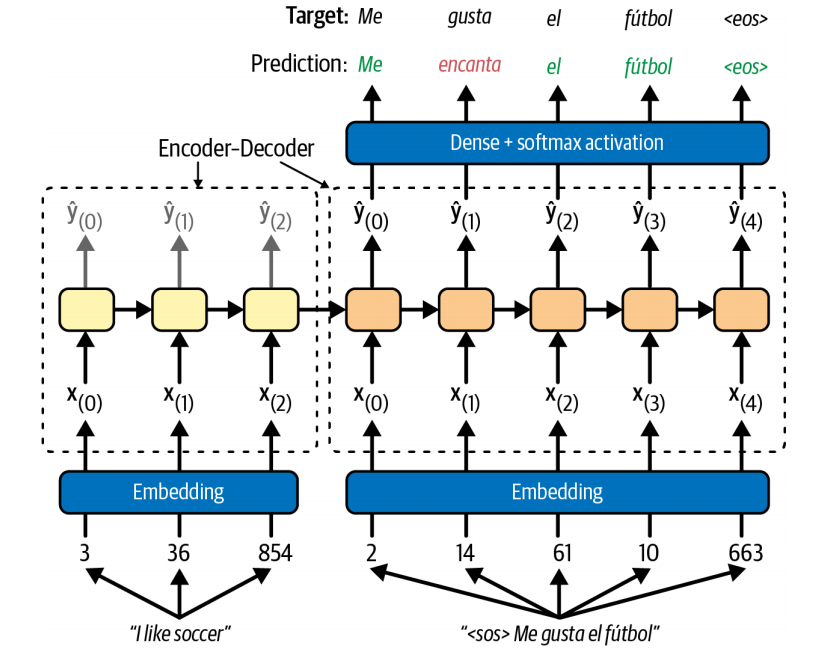

简而言之，其体系结构如下：英语句子作为编码器的输入被输入，解码器输出西班牙语翻译。注意，西班牙语翻译在训练期间也被用作解码器的输入，但被移了一步。换句话说，在训练过程中，解码器被它应该输出的单词作为输入，而不管它实际输出什么。这被称为 **teacher forcing** ——一种能显著加快训练和提高模型表现的技术。对于第一个单词，解码器被给予一个 **序列开始（start-of-sequence，SOS）** 标记，并且解码器被期望用一个 **序列结束（end-of-sequence，EOS）** 标记来结束这个句子。

每个单词最初都由其 ID 表示（例如，854 代表单词“soccer”）。接下来，**Embedding** 层返回单词嵌入。然后将这些单词嵌入馈送到编码器和解码器。

在每一步，解码器都会为输出词汇表（即西班牙语）中的每个单词输出一个分数，然后 softmax 激活函数将这些分数转化为概率。例如，在第一步，单词“Me”可能有 7% 的概率，“Yo”可能有 1% 的概率，依此类推。输出概率最高的词。这非常类似于常规分类任务，实际上您可以使用 **"sparse_categorical_crossentropy"** 损失来训练模型，就像我们在 char-RNN 模型中所做的那样。

注意，在推理时（训练之后），您将没有目标句子提供给解码器。相反，您需要向它提供它在上一步中刚刚输出的单词，如下图所示（这将需要一个在图中没有显示的嵌入查找）。

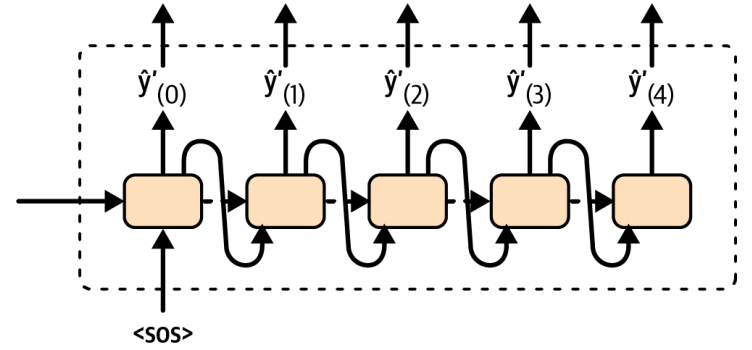

**注意**：在 2015 年的一篇论文中，Samy Bengio 等人。建议在训练期间逐渐从向解码器提供先前的 **target token** 切换为向解码器提供先前的 **output token** 。

让我们来建立和训练这个模型吧！首先，我们需要下载一个英语/西班牙语句子对的数据集：

In [9]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"

path = tf.keras.utils.get_file("spa-eng.zip", origin=url,
                               cache_dir="datasets", extract=True)

text = (Path(path).with_name("spa-eng") / "spa.txt").read_text(encoding='utf-8')

每一行包含一个英语句子和相应的西班牙语翻译，由一个 tab 分隔。我们将首先删除 **TextVectorization** 层没有处理的西班牙语字符，然后我们将解析句子对并打乱它们。最后，我们将把它们分成两个单独的列表，每种语言都有一个：

In [10]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")

pairs = [line.split("\t") for line in text.splitlines()]

np.random.seed(42)  # extra code – ensures reproducibility on CPU

np.random.shuffle(pairs)

sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

让我们来看看前三对句子：

In [11]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


接下来，让我们创建两个 **TextVectorization** 层，每种语言一个，并使它们适应文本：

In [12]:
vocab_size = 1000
max_length = 50

text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)

text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)

text_vec_layer_en.adapt(sentences_en)

text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

这里有一些事情需要注意：

- 我们将词汇量限制在1000个，这非常小。这是因为训练集不是很大，也因为使用一个小的值会加速训练。最先进的翻译模型通常使用更大的词汇量（例如，30000个），更大的训练集（千兆字节）和更大的模型（数百甚至数千兆字节）。例如，看看赫尔辛基大学的 Opus-MT 模型，或者 Facebook 的 M2M-100 模型。
- 由于数据集中的所有句子最多有 50 个单词，我们将 **output_sequence_length** 设置为 50 ：这样输入序列将自动被零填充，直到它们都是 50 个 token 长。如果在训练集中有任何一个超过 50 个 token 的句子，它将被裁剪为 50 个 token 。
- 对于西班牙语文本，当适应 **TextVectorization** 层时，我们在每个句子中添加“startofseq”和“endofseq”：我们将使用这些词作为 SOS 和 EOS tokens。你可以使用任何其他的单词，只要它们不是真正的西班牙语单词。

让我们来检查一下这两个词汇表中的前 10 个 token 。它们从填充 token、未知 token、SOS 和 EOS token（仅在西班牙语中使用）开始，然后是实际的单词，按频率递减排序：

In [13]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [14]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

接下来，让我们创建训练集和验证集(如果需要的话，也可以创建一个测试集）。我们将使用前 10 万对句子对进行训练，其余的用于验证。解码器的输入是西班牙语句子加上一个 SOS 标记前缀。目标是西班牙语句子加上一个 EOS 后缀：

In [15]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])

X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])

Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

好吧，我们现在已经准备好建立我们的翻译模型了。我们将为此使用 **函数API**，因为该模型不是顺序的。它需要两个文本输入，一个用于编码器，一个用于解码器，所以让我们从它开始：

In [16]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

接下来，我们需要使用我们之前准备的 **TextVectorization** 层对这些句子进行编码，然后为每种语言使用一个 **Embedding** 层，使用 **mask_zero=True** ，以确保掩码被自动处理。嵌入的大小是一个超参数，你可以调整，一如既往：

In [17]:
embed_size = 128

encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)

encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

**注意**：当语言共享许多单词时，对编码器和解码器使用相同的嵌入层可以获得更好的性能。

现在让我们创建编码器，并传递它嵌入的输入：

In [18]:
encoder = tf.keras.layers.LSTM(512, return_state=True)

encoder_outputs, *encoder_state = encoder(encoder_embeddings)

为了简单起见，我们只使用了一个 **LSTM** 层，但是您可以堆叠其中的几个层。我们还设置了 **return_state=True** 来获得对层的最终状态的引用。由于我们使用 **LSTM** 层，实际上有两种状态：短期状态和长期状态。层分别返回这些状态，这就是为什么我们必须编写 **\*encoderstate** 来将列表中的两个状态分组。现在我们可以使用这个（双）状态作为解码器的初始状态：

In [19]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)

decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

接下来，我们可以将解码器的输出通过一个具有 softmax 激活函数的 **Dense** 层，以得到每一步的单词概率：

In [20]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")

Y_proba = output_layer(decoder_outputs)

**优化输出层（Optimizing the Output Layer）**：当输出词汇量很大时，输出每个可能单词的概率可能会非常慢。如果目标词汇表包含 50000 个西班牙语单词而不是 1000 个，那么解码器将输出 50000 维向量，并且在如此大的向量上计算 softmax 函数的计算量会非常大。为避免这种情况，一种解决方案是仅查看模型输出的正确单词和错误单词随机样本的 logits，然后仅基于这些 logits 计算损失的近似值。这种采样 softmax 技术由 Sébastien Jean 等人于 2015 年引入。在 TensorFlow 中，您可以在训练期间为此使用 **tf.nn.sampled_softmax_loss()** 函数，并在推理时使用正常的 **softmax** 函数（采样 softmax 不能在推理时使用，因为它需要知道目标）。你可以做另一件事来加速训练——它与采样 softmax 兼容——是将输出层的权值绑定到解码器的嵌入矩阵的转置上（你将在第 17 章中看到如何绑定权值）。这大大减少了模型参数的数量，从而加快了训练速度，有时也可能提高模型的准确性，特别是在你没有大量训练数据的情况下。嵌入矩阵等价于独热编码，然后是一个没有偏差项和没有激活函数的线性层，将单热向量映射到嵌入空间。输出层则相反。因此，如果模型能够找到一个嵌入矩阵的转置接近其逆（这样的矩阵称为正交矩阵），那么就不需要为输出层学习一组单独的权值。

就这样！我们只需要创建Keras模型，编译它，并训练它：

In [31]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 69s 20ms/step - loss: 0.4169 - accuracy: 0.4245 - val_loss: 0.3089 - val_accuracy: 0.5210
Epoch 2/10
3125/3125 [==============================] - 58s 19ms/step - loss: 0.2662 - accuracy: 0.5708 - val_loss: 0.2391 - val_accuracy: 0.6033
Epoch 3/10
3125/3125 [==============================] - 59s 19ms/step - loss: 0.2096 - accuracy: 0.6418 - val_loss: 0.2081 - val_accuracy: 0.6473
Epoch 4/10
3125/3125 [==============================] - 66s 21ms/step - loss: 0.1768 - accuracy: 0.6864 - val_loss: 0.1938 - val_accuracy: 0.6656
Epoch 5/10
3125/3125 [==============================] - 67s 21ms/step - loss: 0.1534 - accuracy: 0.7200 - val_loss: 0.1877 - val_accuracy: 0.6761
Epoch 6/10
3125/3125 [==============================] - 66s 21ms/step - loss: 0.1346 - accuracy: 0.7473 - val_loss: 0.1856 - val_accuracy: 0.6798
Epoch 7/10
3125/3125 [==============================] - 66s 21ms/step - loss: 0.1184 - accuracy: 0.7726 - val_loss: 0.1867 -

经过训练后，我们可以使用这个模型将新的英语句子翻译成西班牙语。但它并不像调用 **model.predict()** 那么简单，因为解码器期望在前一个 time step 中预测的单词作为输入。一种方法是编写一个自定义存储单元，该单元跟踪之前的输出，并在下一个 time step 将其提供给编码器。然而，为了保持简单，我们可以多次调用模型，预测每一轮多用一个单词。让我们写一个实用函数：

In [21]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

该函数只是每次不断预测一个单词，并逐渐完成翻译，一旦到达 EOS 标记，它就会停止。让我们试一试吧！

In [33]:
translate("I like soccer")

1/1 [==============================] - 0s 23ms/step


'me gusta el fútbol'

它有效！至少对于很短的句子是这样的。如果你尝试玩这个模型一段时间，你会发现它还不是双语的，特别是对于更长的句子。例如：

In [35]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 42ms/step


'me gusta la [UNK] y a la tarde'

翻译中写着：“我喜欢足球，有时甚至喜欢公交车。”那么，你该如何改进它呢？一种方法是增加训练集的大小，并在编码器和解码器中添加更多的 LSTM 层。但这只会让你走到目前为止，所以让我们看看更复杂的技术，从双向循环层开始。

### 3.1 双向 RNNs（Bidirectional RNNs）

在每个 time step 中，一个规则的循环层在生成输出之前只查看过去和现在的输入。换句话说，它是因果关系的，这意味着它不能展望未来。这种类型的 RNN 在预测时间序列时，或在序列到序列（seq2seq）模型的解码器中，都是有意义的。但是对于像文本分类这样的任务，或者在seq2seq模型的编码器中，通常最好在编码一个给定的单词之前先看下一个单词。

例如，考虑一下短语“the right arm”、“the right person”和“the right to criticize”：要正确地编码“right”这个词，你需要向前看。一种解决方案是在相同的输入上运行两个循环层，一个从左到右读取单词，另一个从右到左读取单词，然后在每个 time step 中组合它们的输出，通常是通过将它们连接起来。这是双向循环层所做的事情（参见下图)。

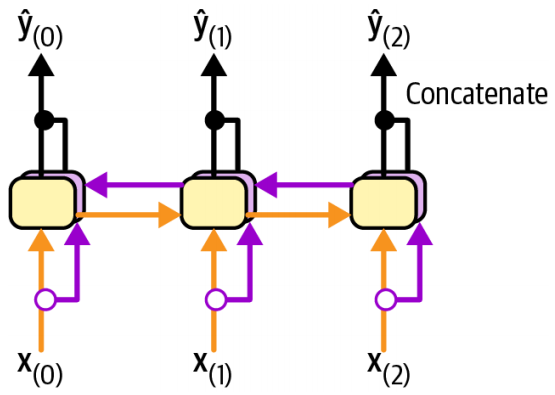

要在 Keras 中实现一个双向循环层，只需在 **tf.keras.layers.Bidirectional** 层中包装一个循环层。

例如，在我们的翻译模型中，下面的 **Bidirectional** 可以作为编码器：

In [36]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

**注意**：**Bidirectional** 层将创建一个 **GRU** 层的克隆（但方向相反），它将同时运行这两个层并连接它们的输出。因此，尽管 **GRU** 层有 10 个单元，但 **Bidirectional** 层将在每个 time step 中输出20个值。

只有一个问题。这一层现在将返回四种状态，而不是两种：正向 LSTM 层的最终短期和长期状态，以及后向 LSTM 层的最终短期和长期状态。我们不能直接使用这种四重状态作为解码器的 LSTM 层的初始状态，因为它只期望两种状态（短期和长期）。我们不能使解码器双向化，因为它必须保持因果关系：否则它将在训练期间作弊，而它将不会工作。相反，我们可以连接这两个短期状态，也可以连接这两个长期状态：

In [37]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

现在让我们来看看另一种流行的技术，它可以极大地提高在推理时的翻译模型的性能：**集束搜索（Beam Search）**。

### 3.2 集束搜索（Beam Search）

假设你训练了一个编码器-解码器模型，然后用它把句子“I like soccer”翻译成西班牙语。你希望它能输出正确的翻译“me gusta el fútbol”，但不幸的是它输出“me gustan los jugadores”，意思是“I like the players”。看看训练集，你会注意到很多句子，比如“I like cars”，翻译成“me gustan los autos”，所以模型在看到“I like”后输出“me gustan los”并不荒谬。不幸的是，在这个案例中，这是一个错误，因为“soccer”是单一的。模型不能回去修复它，所以它试图尽可能地完成句子，在这种情况下使用“jugadores”这个词。我们如何才能给模型一个机会回去修复它之前犯的错误？最常见的解决方案之一是 **集束搜索（beam search）**：它跟踪 $k$ 个最有希望的句子（比如前三个），在每个解码器步骤中，它试图将它们扩展为一个单词，只保留 $k$ 个最有可能的句子。参数 $k$ 被称为 **集束宽度（beam width）**。

例如，假设您使用模型使用集束宽度为 3 的集束搜索来翻译句子“I like soccer”（参见下图）。

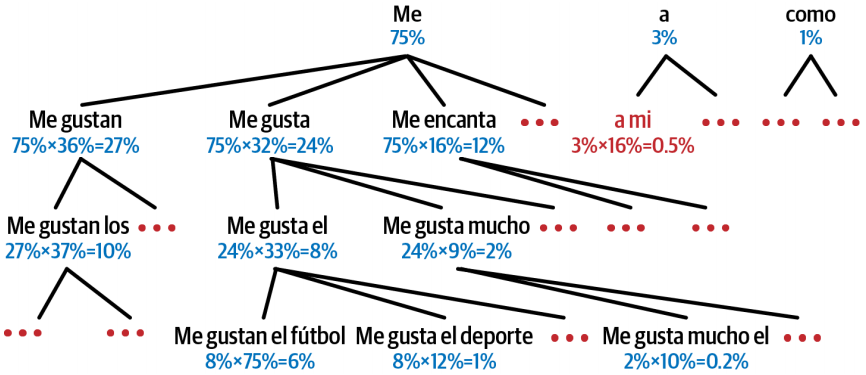

在第一个解码器步骤中，模型将输出翻译句子中每个可能的第一个单词的估计概率。假设前三个单词分别是“me”（75%的估计概率）、“a”（3%）和“como”（1%）。这是我们到目前为止的候选名单。接下来，我们使用这个模型来找到每个句子的下一个单词。对于第一句话（“me”），也许模型输出单词“gustan”的概率为 36 %，单词“gusta”的概率为 32 %，单词“encanta”的概率为 16 %，以此类推。

请注意，假设句子以“me”开头，这些实际上是条件概率。对于第二个句子（“a”），模型可能会为单词“mi”输出 50% 的条件概率，依此类推。假设词汇表有 1000 个单词，我们最终会得到每个句子 1000 个概率。

接下来，我们计算我们考虑的 3000 个双词句子中每个句子的概率 (3×1000)。我们通过将每个单词的估计条件概率乘以它完成的句子的估计概率来做到这一点。

例如，句子“me”的估计概率是75%，而单词“gustan”的估计条件概率（假设第一个单词是“me”）是 36 %，所以句子“me gustan”的估计概率是 75%×36%=27% 。在计算了所有 3000 个双单词句子的概率后，我们只保留了前 3 个。在这个例子中，他们都以“me”这个词开头：“me gustan”（27%），“me gusta”（24%）和“me encanta”（12%）。现在，“me gustan”这句话赢了，但“me gusta”还没有被取消。

然后我们重复同样的过程：我们使用这个模型来预测这三个句子中的下一个单词，然后我们计算我们考虑的所有 3000 个三个单词句子的概率。也许排名前三名的是“me gustan los”（10%）、“me gusta el”（8%）和“me gusta mucho”（2%）。下一步，我们可能会得到“me gusta el fútbol”（6%），“me gusta mucho el”（1%）和“me gusta el deporte”（0.2%）。注意，“me gustan”被删除了，正确的翻译现在在前面。我们在不进行任何额外训练的情况下提高了解码器模型的性能，只是通过更明智地使用它。

**注意**：TensorFlow Addons 库包含一个完整的 seq2seq API，它允许您构建具有关注性的编码器-解码器模型，包括集束搜索等等。然而，它的文档目前非常有限。实现集束搜索是一个很好的练习，所以试一试吧！查看本章的笔记本，了解一个可能的解决方案。

有了所有这些，你就可以为相当短的句子得到相当好的翻译。不幸的是，这个模型在翻译长句方面真的很糟糕。这个问题再次来自于 RNN 的短期记忆有限。**注意力机制（Attention mechanisms）** 是解决这个问题的一种改变游戏规则的创新。

In [29]:
# extra code – a basic implementation of beam search

def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # encoder input
    X_dec = np.array(["startofseq"])  # decoder input
    y_proba = model.predict((X, X_dec))[0, 0]  # first token's probas
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # list of best (log_proba, translation)
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]
    
    # extra code – displays the top first words in verbose mode
    if verbose:
        print("Top first words:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = np.array([sentence_en])  # encoder input
            X_dec = np.array(["startofseq " + translation])  # decoder input
            y_proba = model.predict((X, X_dec))[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # extra code – displays the top translation so far in verbose mode
        if verbose:
            print("Top translations so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [30]:
# extra code – shows how the model making an error
sentence_en = "I love cats and dogs"
translate(sentence_en)

1/1 [==============================] - 0s 37ms/step


'me [UNK] los gatos y los gatos'

In [31]:
# extra code – shows how beam search can help
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 [==============================] - 0s 36ms/step
Top first words: [(-0.39663517, 'me'), (-2.001631, 'yo'), (-2.7512906, 'a')]
1/1 [==============================] - 0s 31ms/step
Top translations so far: [(-0.70920706, 'me [UNK]'), (-2.1310687, 'me gustan'), (-2.5384283, 'yo me')]
1/1 [==============================] - 0s 35ms/step
Top translations so far: [(-0.79332364, 'me [UNK] los'), (-2.2521214, 'me gustan los'), (-2.7544742, 'yo me [UNK]')]
1/1 [==============================] - 0s 34ms/step
Top translations so far: [(-1.081513, 'me [UNK] los gatos'), (-2.5374591, 'me gustan los gatos'), (-2.5666566, 'me [UNK] los perros')]
1/1 [==============================] - 0s 34ms/step
Top translations so far: [(-1.7613978, 'me [UNK] los gatos y'), (-1.9017711, 'me [UNK] los gatos endofseq'), (-2.722362, 'me gustan los gatos y')]
1/1 [==============================] - 0s 36ms/step
Top translations so far: [(-1.9017711, 'me [UNK] los gatos endofseq'), (-2.590049, 'me [UNK] los gatos y los'

'me [UNK] los gatos'

## 4. 注意力机制（Attention Mechanisms）

考虑一下从单词“soccer”到其翻译“fútbol”的路径：它相当长！这意味着这个词（以及所有其他词）的表示在实际使用之前需要经过许多步骤。我们不能缩短这条路吗？

这是 Dzmitry Bahdanau 等人在 2014 年发表的具有里程碑意义的论文中的核心思想，作者在论文中引入了一种技术，使解码器能够在每个时间步专注于适当的单词（由编码器编码）。例如，在解码器需要输出单词“fútbol”的 time step，它会将注意力集中在单词“soccer”上。这意味着从输入单词到翻译的路径现在要短得多，因此 RNN 的短期记忆限制的影响要小得多。注意力机制彻底改变了神经机器翻译（以及一般的深度学习），显着改进了现有技术，特别是对于长句子（例如，超过 30 个单词）。

**注意**：NMT 中最常用的指标是 **双语评估替补（bilingual evaluation understudy，BLEU）** 分数，它将模型产生的每个翻译与人类产生的几个好的翻译进行比较：它计算出现在任何目标翻译中的 **n-gram（n 个单词的序列）** 的数量，并调整分数以考虑目标翻译中生成的 n-gram 的频率。

下图显示了我们添加了注意机制的编码器-解码器模型。

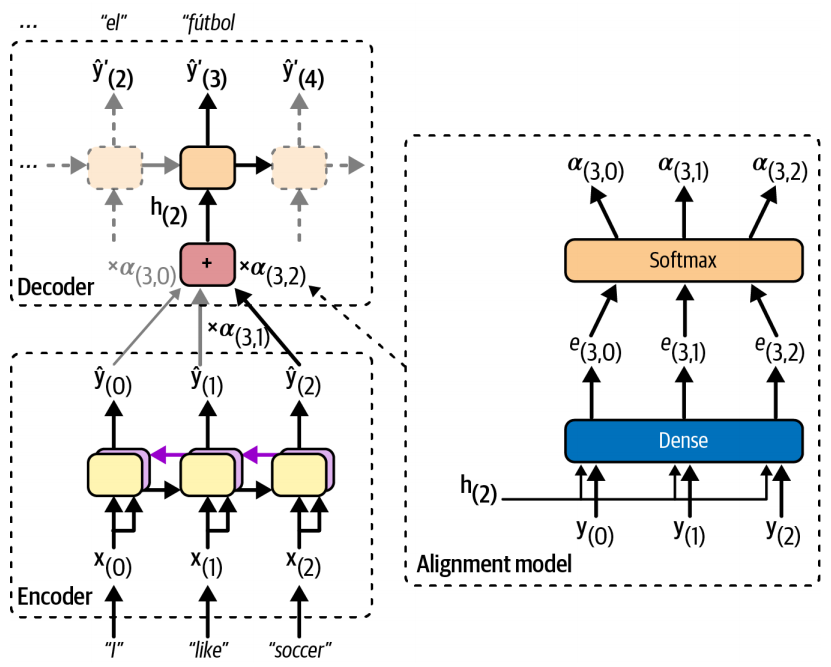

在左边，你有编码器和解码器。我们不是仅仅将编码器的最终隐藏状态发送到解码器，以及每一步的前一个目标字（仍然完成，尽管没有在图中显示），我们现在也将编码器的所有输出发送到解码器。由于解码器不能一次处理所有这些编码器输出，因此需要聚合它们：在每个 time step 中，解码器的存储单元计算所有编码器输出的加权和。这就决定了在这一步中它将关注哪些单词。权值 $\alpha_{(t,i)}$ 是在第 $t$ 个解码器 time step 上的第 $i$ 个编码器输出的权值。例如，如果权重 $\alpha_{(3,2)}$ 比权重 $\alpha_{(3,0)}$ 和 $\alpha_{(3,1)}$ 大得多，那么解码器将更加关注单词 $\#2$ （“soccer”）的编码器的输出，而不是其他两个输出，至少在这个 time step 。其余的解码器像前面一样工作：在每个 time step，存储单元接收我们刚刚讨论的输入，加上前一个 time step 的隐藏状态，最后（尽管在图中没有表示）它接收前一个 time step 的目标字（或在推理时间，前一个 time step 的输出）。

但是这些 $\alpha_{(t,i)}$ 的权重从何而来呢？它们是由一个叫做 **对齐模型（alignment model）**（或 **注意层（attention layer）**）的小神经网络生成的，它与编码器-解码器模型的其他部分共同训练。这个对齐模型在下图的右侧所示。

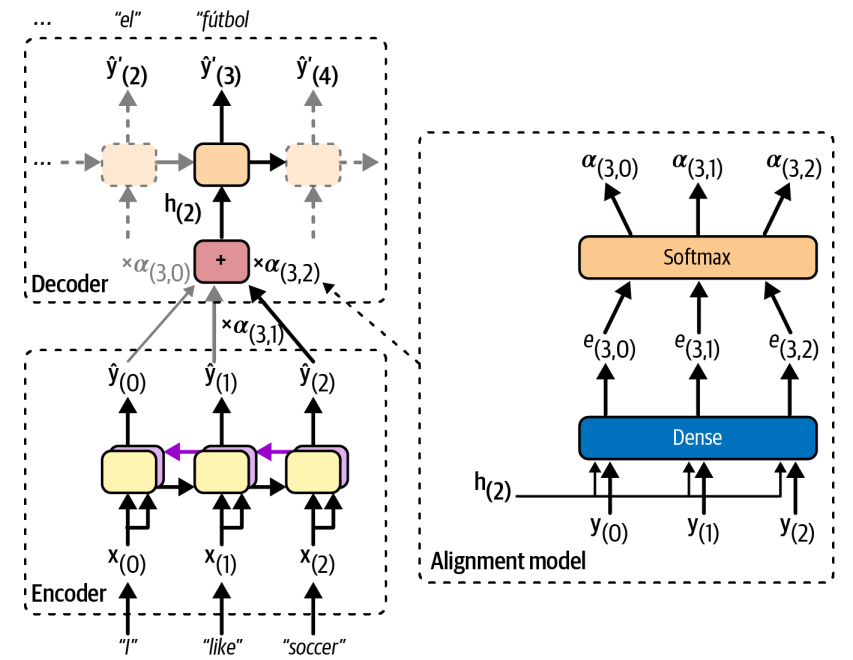

它首先是一个由单个神经元组成的 **Dense** 层，该神经元处理每个编码器的输出，以及解码器之前的隐藏状态（例如，$\pmb{h}_{(2)}$）。该层为每个编码器输出（例如，$\pmb{e}_{(3,2)}$ )输出分数（或能量）：该分数测量每个输出与解码器先前的隐藏状态对齐程度。例如，在上图中，模型已经输出了“me gusta el”（意思是“I like”），所以它现在期待一个名词：单词“soccer”与当前状态最一致，所以它得到了一个高分。最后，所有的分数都通过一个 softmax 层来获得每个编码器输出的最终权重（例如，$\alpha_{(3,2)}$）。对于一个给定的解码器 time step 的所有权值加起来为 1 。这种特殊的注意力机制被称为 **巴赫达瑙注意力（Bahdanau attention）**（以 2014 年该论文的第一作者的名字命名）。由于它将编码器的输出与解码器之前的隐藏状态连接起来，因此它有时被称为 **连接注意力（concatenative attention）（或附加注意（additive attention））** 。

**注意**：如果输入的句子是 $n$ 个单词长，并且假设输出的句子大约一样长，那么这个模型将需要计算大约 $n^2$ 个权值。幸运的是，这种二次计算复杂度仍然是易于处理的，因为即使是长句子也没有数千个单词。

另一种常见的注意机制，称为 **朗注意力（Luong attention）** 或 **乘法注意力（multiplicative attention）**，在 2015 年 19 年提出。因为对齐模型的目标是测量编码器的输出和解码器的隐藏状态之间的相似性，作者提出简单计算点积（见第四章）的这两个向量，这通常是一个相当好的相似度，并且现代硬件可以非常有效地计算它。为了做到这一点，两个向量必须具有相同的维数。点积给出一个分数，所有的分数（在给定的解码器 time step 中）通过一个 softmax 层来给出最终的权重，就像在 **巴赫达瑙注意力（Bahdanau attention）** 中一样。另一个简化 Luong 等人的方法被提出，使用解码器在当前 time step 的隐藏状态而不是在之前的 time step 的隐藏状态（即 $\pmb{h}_{(t)}$ 而不是 $\pmb{h}_{(t-1)}$ ），然后使用注意力机制的输出（记为 $\tilde{\pmb{h}}_{(t)}$ ）直接计算解码器的预测，而不是使用它来计算解码器的当前隐藏状态。研究人员还提出了点积机制的一种变体，即编码器的输出在计算点积之前，首先经过一个全连接层（没有偏差项）。这被称为“**general**”点积方法。研究人员将两种点积方法与 **连接注意力机制（concatenative attention mechanism）**（添加一个重新缩放的参数向量 $\pmb{v}$）进行了比较，他们发现点积变体比 **连接注意力（concatenative attention）** 表现得更好。因此，**连接注意力（concatenative attention）** 现在更少使用了。

这三种注意机制的方程总结在如下公式中：

**注意力机制（Attention mechanisms）**：

$$ \tilde{\pmb{h}}_{(t)}=\sum_{i}\alpha_{(t,i)}\pmb{y}_{(i)}\ ,\
with\ \alpha_{(t,i)}=\frac{exp(e_{(t,i)})}{\sum_{i'}exp(e_{(t,i')})}\
and\ e_{(t,i)}=\left\{
\begin{aligned}
\pmb{h}_{(t)}^T\pmb{y}_{(i)}\ ,\ dot \\
\pmb{h}_{(t)}^T\pmb{W}\pmb{y}_{(i)}\ ,\ general \\
\pmb{v}^Ttanh(\pmb{W}[\pmb{h}_{(t)};\pmb{y}_{(i)}])\ ,\ concat
\end{aligned}
\right.
$$

Keras 为 **朗注意力（Luong attention）** 提供了一个 **tf.keras.layers.Attention** 层，为 **巴赫达瑙注意力（Bahdanau attention）** 的 **AdditiveAttention** 层。让我们把 **朗注意力（Luong attention）** 加到我们的编码器-解码器模型中。因为我们需要将所有编码器的输出传递给 **Attention** 层，所以我们首先需要在创建编码器时设置 **return_sequences=True** ：

In [22]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

In [23]:
# extra code – this part of the model is exactly the same as earlier
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

decoder = tf.keras.layers.LSTM(512, return_sequences=True)

decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

接下来，我们需要创建注意力层，并将其传递给解码器的状态和编码器的输出。然而，要在每一步访问解码器的状态，我们需要编写一个自定义存储单元。为了简单起见，让我们使用解码器的输出，而不是它的状态：在实际操作中，这也工作得很好，而且它更容易编码。然后我们将注意力层的输出直接传递到输出层，如 Luong 注意力的论文所示：

In [24]:
attention_layer = tf.keras.layers.Attention()

attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")

Y_proba = output_layer(attention_outputs)

就这样！如果你训练这个模型，你会发现它现在可以处理更长的句子。例如：

In [25]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 94s 25ms/step - loss: 0.4058 - accuracy: 0.4517 - val_loss: 0.2735 - val_accuracy: 0.5772
Epoch 2/10
3125/3125 [==============================] - 74s 24ms/step - loss: 0.2367 - accuracy: 0.6202 - val_loss: 0.2175 - val_accuracy: 0.6447
Epoch 3/10
3125/3125 [==============================] - 75s 24ms/step - loss: 0.1966 - accuracy: 0.6741 - val_loss: 0.1958 - val_accuracy: 0.6768
Epoch 4/10
3125/3125 [==============================] - 74s 24ms/step - loss: 0.1753 - accuracy: 0.7021 - val_loss: 0.1871 - val_accuracy: 0.6882
Epoch 5/10
3125/3125 [==============================] - 74s 24ms/step - loss: 0.1601 - accuracy: 0.7223 - val_loss: 0.1821 - val_accuracy: 0.6965
Epoch 6/10
3125/3125 [==============================] - 74s 24ms/step - loss: 0.1477 - accuracy: 0.7389 - val_loss: 0.1810 - val_accuracy: 0.6970
Epoch 7/10
3125/3125 [==============================] - 75s 24ms/step - loss: 0.1370 - accuracy: 0.7538 - val_loss: 0.1809 -

In [27]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 38ms/step


'me gusta el fútbol y [UNK] a la playa'

In [32]:
beam_search("I like soccer and also going to the beach", beam_width=3,
            verbose=True)

1/1 [==============================] - 0s 35ms/step
Top first words: [(-0.32032317, 'me'), (-2.272876, 'a'), (-2.7271674, 'yo')]
1/1 [==============================] - 0s 33ms/step
Top translations so far: [(-0.33386162, 'me gusta'), (-2.8750286, 'yo me'), (-3.7147071, 'a [UNK]')]
1/1 [==============================] - 0s 38ms/step
Top translations so far: [(-0.689168, 'me gusta el'), (-2.0574646, 'me gusta fútbol'), (-2.88922, 'yo me gusta')]
1/1 [==============================] - 0s 34ms/step
Top translations so far: [(-0.7653872, 'me gusta el fútbol'), (-2.090508, 'me gusta fútbol y'), (-3.1575956, 'yo me gusta el')]
1/1 [==============================] - 0s 36ms/step
Top translations so far: [(-0.76855963, 'me gusta el fútbol y'), (-3.0965347, 'me gusta fútbol y [UNK]'), (-3.234976, 'yo me gusta el fútbol')]
1/1 [==============================] - 0s 36ms/step
Top translations so far: [(-2.0325255, 'me gusta el fútbol y [UNK]'), (-2.793276, 'me gusta el fútbol y a'), (-3.167873, 'me

'me gusta el fútbol y [UNK] a la playa'

简而言之，注意层提供了一种将模型的注意力集中在部分输入上的方法。但还有另一种方式来看待这一层：**它是一种可微的记忆检索机制**。

例如，让我们假设编码器分析输入的句子“I like soccer”，它设法理解了单词“I”是主语，而单词“like”是动词，所以它将这个信息编码到这些单词的输出中。现在假设译码器已经翻译了主语，它认为下一个应该翻译动词。为此，它需要从输入的句子中获取动词。这类似于字典查找：就好像编码器创建了一个字典{“主语”：“They”，“动词”：“played”，……}，解码器想要查找与 key“verb”对应的值。

然而，该模型没有离散的 token 来表示 key（如“subject”或“verb”）；相反，它对在训练中学习到的这些概念进行了向量表示，因此它用于查找的查询不会完全匹配字典中的任何 key 。解决方案是计算查询和字典中的每个 key 之间的相似度度度量，然后使用 softmax 函数将这些相似度分数转换为加起来为 1 的权重。正如我们之前所看到的，这正是注意力层所做的。如果表示动词的 key 与查询最相似，那么该 key 的权重将接近于1。

接下来，注意层计算相应值的加权和：如果“verb”key 的权重接近于1，那么加权和将非常接近于单词“played”的表示。

这就是为什么 Keras **Attention** 和 **AdditiveAttention** 层都期望有一个列表作为输入，其中包含两个或三个项：**查询（query,也就是任务的内容，例如情感分类、中译英等）**、**键（key，也就是索引/标签，帮助定位到答案）** 和可选的 **值（value，答案）**。如果不传递任何值，则它们将自动等价于这些 key 。因此，再次查看前面的代码示例，**解码器输出是查询**，而**编码器输出都是键和值**。对于每个解码器输出（即每个查询），注意层返回与解码器输出最相似的编码器输出（即键/值）的加权和。

注意机制是一个可训练的记忆提取系统。它非常强大，以至于你可以只使用注意力机制来构建最先进的模型。进入 transformer 架构。

### 4.1 你仅需要注意力：最初的的 transformer 架构（Attention Is All You Need: The Original Transformer Architecture）

在 2017 年的一篇开创性论文中，谷歌的一个研究团队提出了“**Attention Is All You Need**”。他们创建了一个名为 **transformer** 的架构，它显著地改进了 NMT 的最先进水平，而没有使用任何循环层或卷积层，只有注意力机制（加上嵌入层、密集层、标准化层和一些其他的片段）。因为该模型不是周期性的，它不像 RNNs 那样遭受记忆消失或梯度爆炸问题，它可以用更少的步骤进行训练，它更容易在多个 GPU 上并行化，而且它可以比 RNNs 更好地捕获远程模式。原始的 2017 年 **transformer** 架构如下图所示。

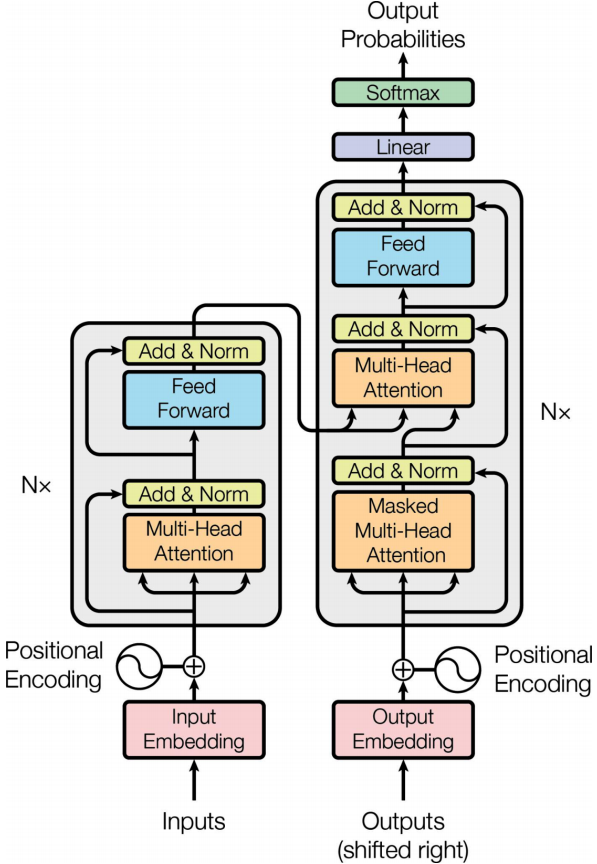

简而言之，左侧是编码器，右侧是解码器。每个嵌入层输出一个形状的三维张量 **\[批大小(batch size), 序列长度(sequence length), 嵌入大小(embedding size)\]** 。之后，张量在通过 transformer 时逐渐变换，但它们的形状保持不变。

如果您使用 NMT transformer，那么在训练期间，您必须将英语句子提供给编码器，相应的西班牙语翻译给解码器，并在每个句子的开头插入一个额外的 SOS token。在推理时，您必须多次调用 transformer ，每次产生一个单词的翻译，并在每一轮中将部分翻译提供给解码器，就像我们之前在 **translate()** 函数中所做的那样。

编码器的角色是逐步转换输入内容——英语句子中的单词表示——直到每个单词的表示都完美地捕捉到了句子上下文中单词的意义。例如，如果你给编码器输入一个句子“I like soccer”，那么“like”这个词就会以一个相当模糊的表示开始，因为这个词在不同的上下文中可能意味着不同的东西：想想“I like soccer”和“It's like that”。但是在经过编码器后，单词的表示应该捕捉到给定句子中“like”的正确含义（即喜欢），以及翻译可能需要的任何其他信息（例如，它是一个动词）。

解码器的作用是逐渐将翻译句子中的每个单词表示转换为翻译过程中下一个单词的单词表示。例如，如果句子翻译是“I like soccer”，解码器的输入句子是“\<SOS\> me gusta el fútbol”，然后经过解码器后，“el”这个单词的单词表示最终将转化为“fútbol”这个词的单词表示。同样，单词“fútbol”的表示将被转换为 EOS token 的表示。

在经过解码器后，每个单词表示都要经过一个带有 softmax 激活函数的最终 **Dense** 层，这将有望高概率输出正确的下一个单词，而低概率输出所有其他单词。预测的句子应该是“me gusta el fútbol \<EOS\>”。

这是整体过程；现在让我们更详细地介绍一下下图：

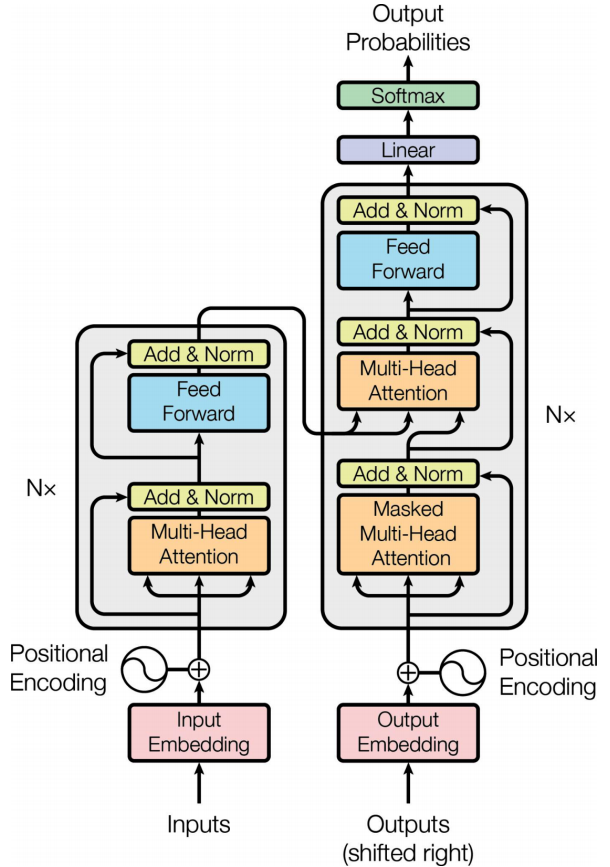

- 首先，请注意编码器和解码器都包含堆叠 $N$ 次的模块。在论文中，$N=6$。整个编码器堆栈的最终输出被馈送到这 $N$ 层中每一层的解码器。
- 放大后，你可以看到你已经熟悉了大多数组件：有两个嵌入层；几个跳过连接，每个都跟着一个标准化层；几个前馈模块分别由两个密集层组成（第一个使用 ReLU 激活函数，第二个没有激活函数）；最后输出层是使用 softmax 激活函数的密集层。如果需要，您还可以在注意力层和前馈模块之后添加一些 dropout 。由于所有这些层都是 **时间分布层（time-distributed layer）**，所以每个单词都独立于所有其他单词进行处理。但是，我们如何才能通过完全单独地看这些单词来翻译一个句子呢？我们不能，所以这就是新组件的作用所在：
  1. 编码器的 **多头注意力（multi-head attention）** 层通过关注（即，注意）同一句子中的所有其他单词来更新每个单词的表示。这就是对“like”一词的模糊表示变得更丰富、更准确，捕捉到它在给定句子中的精确含义。我们将很快讨论这是如何工作的。
  2. 解码器的 **掩码多头注意力（masked multi-head attention）** 层也会做同样的事情，但当它处理一个单词时，它不会关注位于它后面的单词：它是一个因果层。例如，当它处理“gusta”时，它只处理“\<SOS\> me gusta”，而忽略“el fútbol”（否则就是作弊）。
  3. 解码器的上层 **多头注意力（multi-head attention）** 层是解码器注意英语句子中的单词的地方。这叫做 **交叉注意（cross-attention）**，在这种情况下不是 **自我注意（self-attention）**。例如，当解码器在处理“el”并将其表示转换为“fútbol”的表示时，可能会密切关注“soccer”这个词
  4. **位置编码（positional encodings）** 是一种密集向量（很像单词嵌入），它表示每个单词在句子中的位置。然后将第 $n$ 个位置编码添加到每个句子中第 $n$ 个单词嵌入中。这是必要的，因为 transformer 体系结构中的所有层都忽略了单词的位置：如果没有位置编码，您就可以打乱输入序列，这样它就会以同样的方式打乱输出序列。显然，单词的顺序很重要，这就是为什么我们需要以某种方式给转换器提供位置信息：在单词表示中添加位置编码是实现这一目标的一个好方法。

**注意**：在上图中，进入每个 **多头注意力（multi-head attention）** 层的前两个箭头表示键和值，第三个箭头表示查询。**自我注意力（self-attention）** 层，这三个都等于前一层输出的单词表示，而在解码器的上层注意力层，键和值等于编码器的最终单词表示，查询等于前一层输出的单词表示。

让我们从位置编码开始，更详细地介绍一下 transformer 架构的新组件。

#### 4.1.1 位置编码（Positional encodings）

位置编码是一个密集向量，它对句子中单词的位置进行编码：第 $i$ 个位置编码被添加到句子中第 $i$ 个单词的嵌入中。实现这一点的最简单的方法是使用一个 **Embedding** 层，并使它编码批处理中从 0 到最大序列长度的所有位置，然后将结果添加到单词嵌入中。广播规则将确保位置编码应用于每个输入序列。例如，下面是如何添加位置编码到编码器和解码器的输入：

In [33]:
max_length = 50  # max length in the whole training set
embed_size = 128

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)

batch_max_len_enc = tf.shape(encoder_embeddings)[1]

encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))

batch_max_len_dec = tf.shape(decoder_embeddings)[1]

decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

注意，这个实现假设嵌入被表示为规则张量，而不是参差不齐的张量。编码器和解码器为位置编码共享相同的嵌入层，因为它们具有相同的嵌入大小（通常是这种情况）。

没有使用可训练的位置编码，作者选择基于不同频率的正弦和余弦函数使用固定位置编码。位置编码矩阵 $\pmb{P}$ 在如下公式中定义，其中 $P_{p,i}$ 是位于句子中第 $p$ 个位置的单词的编码的第 $i$ 个分量。

**正弦/余弦位置编码（Sine/cosine positional encodings）**：

$$ P_{p,i}=\left\{
\begin{aligned}
sin(p/10000^{i/d})\ ,\ if\ i\ is\ even\\
cos(p/10000^{(i-1)/d})\ ,\ if\ i\ is\ odd
\end{aligned}
\right.
$$

该解决方案可以提供与可训练位置编码相同的性能，并且可以扩展到任意长的句子，而不向模型添加任何参数（但是，当存在大量的预训练数据时，可训练位置编码通常更受青睐）。在将这些位置编码添加到单词嵌入之后，模型的其余部分可以访问句子中每个单词的绝对位置，因为每个位置都有唯一的位置编码（例如，位于句子中第 22 个位置的单词的位置编码由下图左上角的垂直虚线表示，您可以看到该位置是唯一的）。

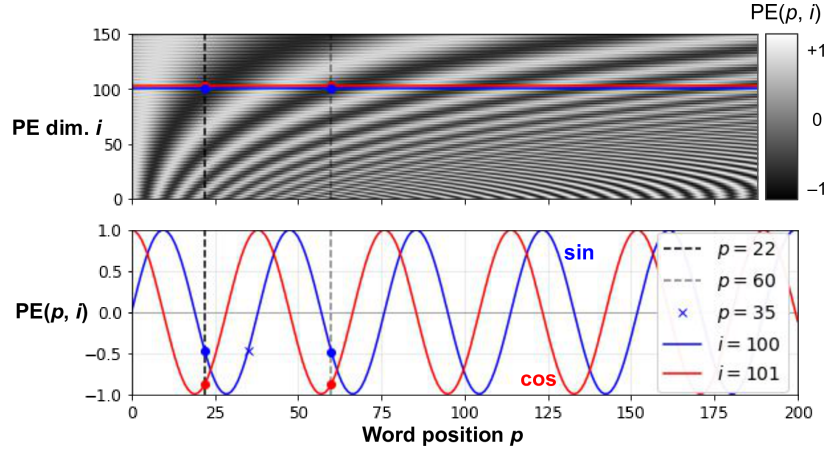

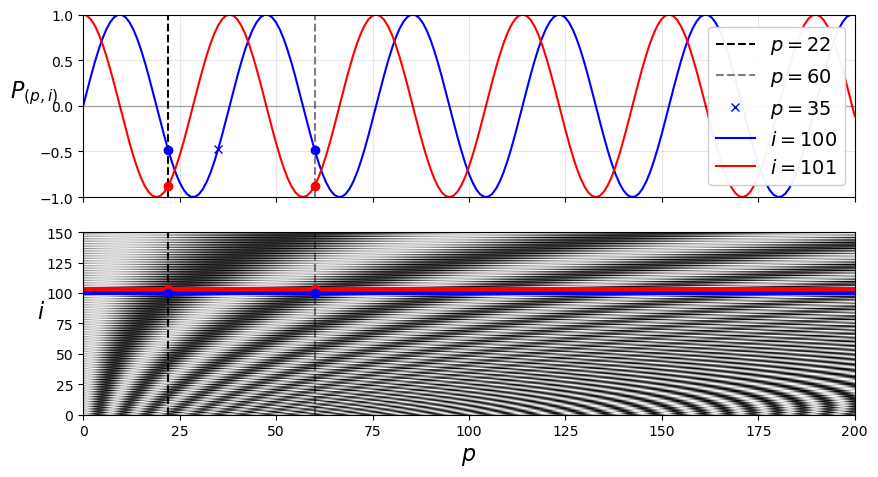

In [41]:
# extra code – this cells generates and saves Figure 16–9
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

此外，振荡函数（正弦和余弦）的选择使模型也有可能学习相对位置。例如，位于 38 个单词之间的单词（例如，在位置 $p=22$ 和 $p=60$）在编码维度 $i=100$ 和 $i=101$ 中总是具有相同的位置编码值，如上图所示。这就解释了为什么我们需要每个频率的正弦和余弦：如果我们只使用正弦（$i=100$ 处的蓝色波），模型将无法区分位置 $p=22$ 和 $p=35$（用十字标记）。

在 TensorFlow 中没有 **PositionalEncoding** 层，但是创建一个并不难。出于效率的原因，我们在构造函数中预先计算了位置编码矩阵。**call()** 方法只是将这个编码矩阵截断为输入序列的最大长度，并将它们添加到输入中。我们还设置了 **supports_masking=True** 来将输入的自动掩码传播到下一层：

In [38]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

让我们使用这一层将位置编码添加到编码器的输入中：

In [39]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)

encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

现在让我们更深入地看看变压器模型的核心，在多头注意力层。

#### 4.1.2 多头注意力（Multi-head attention）

为了理解多头注意力层是如何工作的，我们必须首先了解它所基于的 **缩放点积注意力（scaled dot-product attention）** 层。它的方程在如下方程中以向量化形式表示。它和 **朗注意力（Luong attention）** 一样，除了一个比例因子。

**缩放点积注意力（Scaled dot-product attention）**：

$$ Attention(\pmb{Q},\pmb{K},\pmb{V})=softmax(\frac{\pmb{Q}\pmb{K}^T}{\sqrt{d_{keys}}})\pmb{V} $$

方程中，

- $\pmb{Q}$ 是一个每个查询包含一行的矩阵。它的形状是 $[n_{queries},d_{keys}]$ ，其中 $n_{queries}$ 是查询的数量，$d_{keys}$ 是每个查询和每个键的维数。
- $\pmb{K}$ 是一个每个键包含一行的矩阵。它的形状是 $[n_{keys}，d_{keys}]$ ，其中 $n_{keys}$ 是键和值的数量。
- $\pmb{V}$ 是一个每个值包含一行的矩阵。它的形状是 $[n_{keys}，d_{values}]$ ，其中 $d_{values}$ 是每个值的维数。
- $\pmb{Q}\pmb{K}^T$ 的形状是 $[n_{queries},n_{keys}]$ ：它包含每个 query/key 对的一个相似性分数。为了防止这个矩阵变大，输入序列不能太长（我们将在本章的后面讨论如何克服这个限制）。softmax 函数的输出具有相同的形状，但所有行之和为 1 。最终输出的形状为 $[n_{queries},d_{values}]$ ：每个查询有一行，其中每一行表示查询结果（值的加权和）。
- 缩放因子 $\frac{1}{\sqrt{d_{keys}}}$ 降低了相似性分数，以避免饱和的 softmax 函数，这将导致微小的梯度。
- 在计算 softmax 之前，可以通过在相应的相似度分数中添加一个非常大的负值来掩盖一些 key/value 对。这在掩码多头注意层中很有用。

如果您在创建 **tf.keras.layers.Attention** 层时设置了 **use_scale=True** ，然后它将创建一个额外的参数，让该层学习如何正确地降低相似性分数。在 transformer 模型中使用的 **缩放点积注意力（scaled dot-product attention）** 几乎是相同的，除了它总是通过相同的因子 $\frac{1}{\sqrt{d_{keys}}}$ 来缩放相似性分数。

请注意，**Attention** 层的输入就像 $\pmb{Q}$、$\pmb{K}$ 和 $\pmb{V}$ 一样，除了有一个额外的批处理维度（第一个维度）。在内部，该层仅通过一次调用 **tf.matmul(queries, keys)** 来计算批处理中所有句子的所有注意力分数：这使得它非常高效。事实上，在 TensorFlow 中，如果 $A$ 和 $B$ 是超过两个维度的张量，比如形如 $[2,3,4,5]$ 和 $[2,3,5,6]$ ，那么 **tf.matmul(A, B)** 将把这些张量视为 2×3 数组，其中每个单元包含一个矩阵，它将乘以相应的矩阵：$A$ 中第 $i$ 行和第 $j$ 列的矩阵将乘以 $B$ 中第 $i$ 行和第 $j$ 列的矩阵。由于 4×5 矩阵与 5×6 矩阵的乘积是一个 4×6 矩阵，**tf.matmul(A, B)** 将返回一个形如 $[2,3,4,6]$ 的数组。

现在我们已经准备好去看看多头注意层了。其体系结构如下图所示：

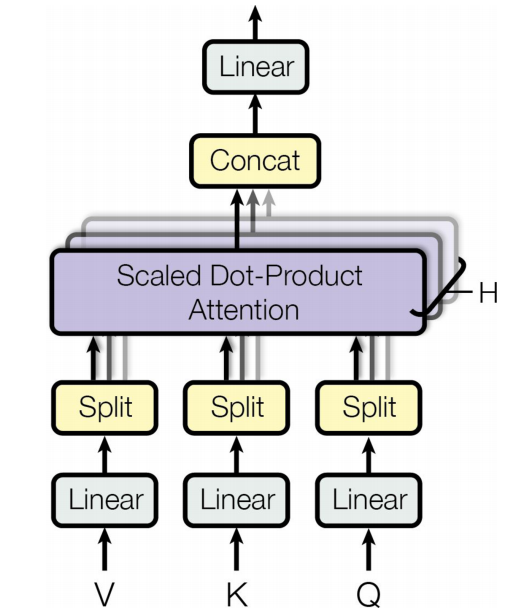

正如您所看到的，它只是一堆 **缩放点积注意力（scaled dot-product attention）** 层，每个层之前都有值、键和查询的线性转换（即，没有激活函数的时间分布密集层）。所有的输出都被简单地连接起来，它们经过最终的线性变换（同样是时间分布层）。

但是为什么呢？这种架构背后的直觉是什么？好吧，再考虑一下“I like soccer”中的“like”这个词。编码器足够聪明来编码它是一个动词的事实。但是，由于位置编码，单词表示也包括它在文本中的位置，它可能包括许多其他对翻译有用的其他特征，比如它是现在时。简而言之，单词表示编码了单词的许多不同特征。如果我们只使用一个单一 **缩放点积注意力（scaled dot-product attention）** 层，我们将只能一次查询所有这些特征。

这就是为什么多头注意力层对值、键和查询应用多种不同的线性变换：这允许模型将单词表示的许多不同投影应用到不同的子空间，每个都关注单词特征的一个子集。也许其中一个线性层会将单词表示投影到一个子空间中，其中剩下的只是单词是动词的信息，另一个线性层将仅提取它是现在时的事实，等等。然后缩放点积注意力层实现查找阶段，最后我们连接所有结果并将它们投影回原始空间。

Keras 包括一个 **tf.keras.layers.MultiHeadAttention** 层，所以我们现在有一切需要用于构建 transformer 的其余部分。让我们从完整的编码器开始，这与下图完全一样，除了我们使用两个块的堆栈（$N=2$），因为我们没有一个巨大的训练集，我们还添加了一点 dropout ：

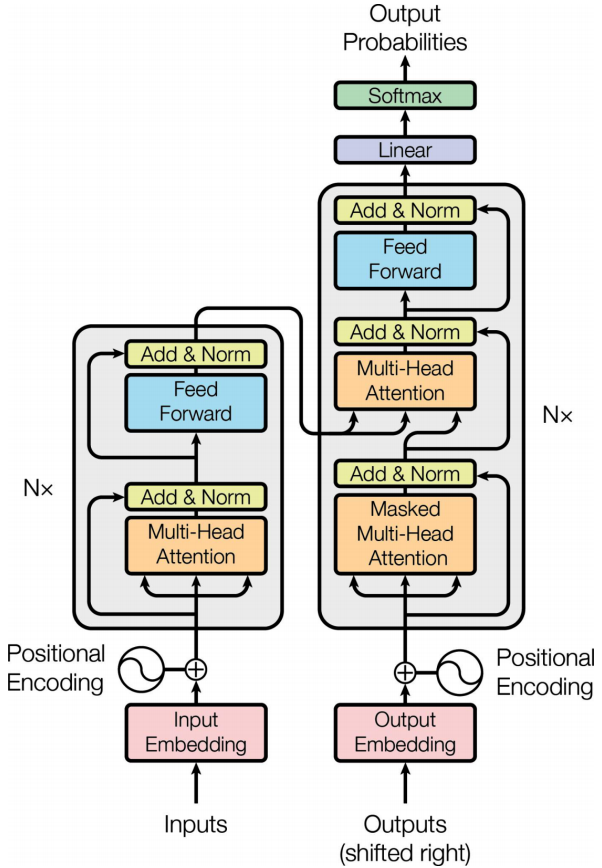

In [42]:
N = 2  # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # for the first Dense layer in each Feed Forward block

encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]

Z = encoder_in

for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

这段代码应该是最简单的，除了一件事：掩码。在撰写本文时，**MultiHeadAttention** 层不支持自动掩码，所以我们必须手动处理它。我们怎么才能做到呢？

**MultiHeadAttention** 层接受一个 **attention_mask** 参数，它是一个形如 $[batch size, max query length, max value length]$ 的布尔张量：对于每个查询序列中的每个 token ，这个掩码指示对应值序列中应该注意哪些 token 。我们想告诉 **MultiHeadAttention** 层忽略值中的所有填充 token 。因此，我们首先使用 **tf.math.not_equal(encoder_input_ids, 0)** 计算填充掩码。这将返回一个形如 $[batch size, max sequence length]$ 的布尔张量。然后，我们使用 $ [:, tf.newaxis]$ 插入第二个轴，以获得一个形如 $[batch size, 1, max sequence length]$ 的掩码。这允许我们在调用 **MultiHeadAttention** 层时使用这个掩码作为 **attention_mask** ：由于广播，每个查询中的所有 token 都将使用相同的掩码。这样，值中的填充 token 将被正确地忽略。

但是，该层将计算每个单独查询 token 的输出，包括填充 token 。我们需要屏蔽与这些填充 token 对应的输出。回想一下，我们在 **Embedding** 层中使用了 **mask_zero** ，并且在 **PositionalEncoding** 层中将 **supports_masking** 设置为 **True** ，因此自动掩码一直传播到 **MultiHeadAttention** 层的输入（**encoder_in**）。我们可以在跳过连接中利用这一点：事实上，**Add** 层支持自动屏蔽，所以当我们添加 **Z** 和 **skip**（最初等于 **encoder_in**）时，输出会自动正确地屏蔽。掩码比代码需要更多的解释。

现在说到解码器上吧！再一次，掩码将是唯一棘手的部分，所以让我们从它开始。第一个多头注意力层是一个自我注意力层，就像在编码器中一样，但它是一个掩码多层注意力层，这意味着它是因果关系的：它应该忽略未来的所有的 token 。所以，我们需要两个掩码：一个 **填充掩码** 和一个 **因果掩码**。让我们创建它们：

In [43]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]

causal_mask = tf.linalg.band_part(  # creates a lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)

填充掩码与我们为编码器创建的掩码完全一样，只是它基于解码器的输入而不是编码器的输入。因果掩码是使用 **tf.linalg.band_part()** 函数创建的，该函数接受一个张量并返回一个副本，其中对角线带外的所有值都设置为零。使用这些参数，我们得到一个大小为 **batch_max_len_dec**（批处理中输入序列的最大长度）的方阵，左下角的三角形为 1 ，右上角的三角形为 0 。 如果我们使用这个掩码作为注意力掩码，我们将得到我们想要的结果：第一个查询 token 将只关注第一个值 token，第二个将只关注前两个，第三个将只关注前三个等等。换句话说，查询 token 不能关注任何未来的值 token 。

现在让我们来构建解码器：

In [44]:
encoder_outputs = Z  # let's save the encoder's final outputs

Z = decoder_in  # the decoder starts with its own inputs

for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

对于第一个注意力层，我们使用 **causal_mask & decoder_pad_mask** 来掩码填充 token 和未来 token 。因果掩码只有两个维度：它缺少批处理维度，但这是可以的，因为广播确保它在批处理中的所有实例中被复制。

对于第二个注意力层，没有什么特别的。唯一需要注意的是，我们使用的是 **encoder_pad_mask** ，而不是 **decoder_pad_mask** ，因为这个注意力层使用编码器的最终输出作为它的值。

我们快完成了。我们只需要添加最终的输出层，创建模型，编译它，然后训练它：

In [45]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 188s 57ms/step - loss: 0.3826 - accuracy: 0.4566 - val_loss: 0.2630 - val_accuracy: 0.5881
Epoch 2/10
3125/3125 [==============================] - 176s 56ms/step - loss: 0.2453 - accuracy: 0.6067 - val_loss: 0.2157 - val_accuracy: 0.6468
Epoch 3/10
3125/3125 [==============================] - 176s 56ms/step - loss: 0.2146 - accuracy: 0.6441 - val_loss: 0.1992 - val_accuracy: 0.6677
Epoch 4/10
3125/3125 [==============================] - 180s 57ms/step - loss: 0.1999 - accuracy: 0.6625 - val_loss: 0.1894 - val_accuracy: 0.6799
Epoch 5/10
3125/3125 [==============================] - 186s 60ms/step - loss: 0.1906 - accuracy: 0.6736 - val_loss: 0.1838 - val_accuracy: 0.6852
Epoch 6/10
3125/3125 [==============================] - 187s 60ms/step - loss: 0.1835 - accuracy: 0.6833 - val_loss: 0.1776 - val_accuracy: 0.6952
Epoch 7/10
3125/3125 [==============================] - 187s 60ms/step - loss: 0.1778 - accuracy: 0.6898 - val_loss: 0

In [46]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 34ms/step


'me gusta el fútbol y yo vamos a la playa'

恭喜你！您已经从头开始构建了一个完整的 transformer ，并训练它进行自动翻译。这已经越来越先进了！

**注意**：Keras 团队创建了一个新的 Keras NLP 项目，包括一个更容易构建 transformer 的 API。你也可能对新的 Keras CV 项目感兴趣。

但这块场地并没有就此结束。现在让我们来探讨一下最近的一些进展。

## 5. transformer 模型的雪崩（An Avalanche of Transformer Models）

2018年被称为“**ImageNet moment for NLP**”。从那时起，进展一直是惊人的，越来越大的基于 transformer 的架构在巨大的数据集上进行训练。

首先，由 Alec Radford 和其他 OpenAI 研究人员撰写的 GPT 论文再次证明了无监督预训练的有效性，就像之前的 ELMo 和 ULMFiT 论文一样，但这次使用了类似 transformer 的架构。作者预先训练了一个大型但相当简单的架构，由 12 个 transformer 模块组成，只使用掩码多头注意力层，就像在原始 transformer 的解码器中一样。他们在一个非常大的数据集上训练它，使用我们与莎士比亚的 char-RNN 相同的自回归技术：只是预测下一个 token 。这是一种自监督学习的形式。然后，他们在各种语言任务上对其进行微调，只对每个任务使用微小的调整。任务是相当多样化的：他们包括文本分类、隐含（是否句子强加，涉及，或暗示句子 $B$ 作为必要的结果），相似性（例如，“Nice weather today”非常类似于“It is sunny”），和问题回答（给定几段文本给出一些上下文，模型必须回答一些多项选择题）。

然后谷歌的 BERT 论文出来了：它还演示了在一个大型语料库上进行自监督预训练的有效性，使用了与 GPT 类似的架构，但只使用了非掩码多头注意力层，就像在原始的 transformer 的编码器中一样。这意味着该模型自然是双向的；因此，B 在 **BERT（Bidirectional Encoder Representations from Transformers）** 中。最重要的是，作者提出了两个预训练任务，可以解释该模型的大部分优势：

- **屏蔽语言模型（Masked language model，MLM）**：句子中的每个词都有 15% 的概率被屏蔽，训练模型预测被屏蔽的词。例如，如果原始句子是“She had fun at the birthday party”，那么模型可能会被赋予句子“She \<mask\> fun at the \<mask\> party”并且它必须预测单词“had”和“birthday”（其他输出将被忽略）。更准确地说，每个选定的词有 80% 的机会被屏蔽，有 10% 的机会被随机词替换（以减少预训练和微调之间的差异，因为模型在微调期间不会看到 \<mask\> 标记），并且有 10% 的机会被单独留下（使模型偏向正确答案）。
- **下一句话预测（Next sentence prediction，NSP）**：该模型被训练来预测两句话是否连续。例如，它应该预测“The dog sleeps”和“It snores loudly”是连续的句子，而“The dog sleeps”和“The Earth orbits the Sun”则不是连续的句子。后来的研究表明，NSP 并不像最初认为的那么重要，所以在后来的大多数架构中被放弃了。

该模型同时在这两个任务上进行训练（参见下图)。

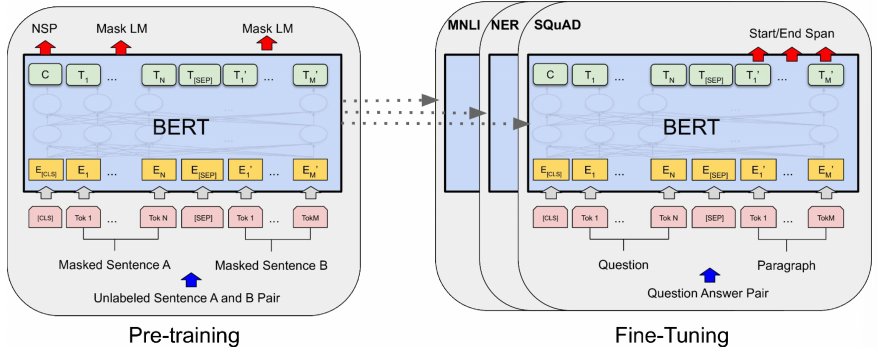

对于 NSP 任务，作者在每个输入的开始处插入一个类标记（\<CLS\>），相应的输出标记表示模型的预测：句子 $B$ 跟随句子 $A$ ，或者它没有。两个输入句子被连接起来，只被一个特殊的分隔标记（\<SEP\>）分开，它们作为模型的输入。为了帮助模型知道每个输入标记属于哪个句子，在每个标记的位置嵌入之上添加了一个 **片段嵌入（segment embedding）**：只有两种可能的片段嵌入，一种用于句子 $A$，一种用于句子 $B$。对于 MLM 任务，一些输入词被屏蔽（正如我们刚刚看到的），模型试图预测这些词是什么。损失仅在 NSP 预测和屏蔽标记上计算，而不是在未屏蔽的标记上计算。

在对一个非常大的文本语料库进行无监督预训练阶段之后，模型会针对许多不同的任务进行微调，每个任务的变化很小。例如，对于情感分析等文本分类，除了第一个对应于类标记的输出标记外，所有输出标记都被忽略，并且新的输出层取代了之前的输出层，这只是 NSP 的二元分类层。

2019年2月，就在 BERT 发表几个月后，Alec Radford、Jeffrey Wu 和其他 OpenAI 研究人员发表了 GPT-2 论文，该论文提出了一个与 GPT 非常相似的架构，但规模更大（超过15亿参数）。研究人员表明，新的和改进的 GPT 模型可以执行 **零样本学习（zero-shot learning，ZSL）**，这意味着它可以在没有任何微调的情况下在许多任务上取得良好的性能。这只是向越来越大的模型比赛的开始：谷歌的 **Switch Transformers**（2021 年 1 月推出）使用 1 万亿参数，很快更大的模型，如 Wu Dao 2.0 模型北京人工智能学院（BAII），2021年6月宣布。

这种走向大模型的趋势的一个不幸后果是，只有资金充足的组织才能负担得起培训这样的模式：它很容易花费数十万美元甚至更多。训练一个单一模型所需的能量相当于一个美国家庭几年的电力消耗；它根本不环保。这些模型中的许多太大了，甚至不能在普通硬件上使用：它们不适合内存，而且会非常慢。最后，有些产品的成本太高，以至于没有公开发布。

幸运的是，聪明的研究人员正在寻找新的方法来缩小 transformer 的尺寸并提高它们的数据效率。例如，来自 Hugging Face 的 Victor Sanh 等人于 2019 年 10 月推出的 **DistilBERT** 模型，是一种基于 BERT 的小型快速 transformer 模型。它可以在 Hugging Face 的优秀模型中心以及数以千计的其他模型中心找到——您将在本章后面看到一个示例。

DistilBERT 使用 **提炼（distillation）**（因此得名）进行训练：这意味着将知识从教师模型转移到学生模型，学生模型通常比教师模型小得多。这通常是通过使用教师对每个训练实例的预测概率作为学生的目标来完成的。令人惊讶的是，提炼通常比在与老师相同的数据集上从头开始训练学生效果更好！事实上，学生会从老师更细致的标签中受益。

在 BERT 之后，几乎每月都会出现更多的 Transformer 架构，通常会改进所有 NLP 任务的最新技术水平：XLNet（2019 年 6 月）、RoBERTa（2019 年 7 月）、StructBERT（2019 年 8 月）、ALBERT（2019 年 9 月）、T5（2019年10月）、ELECTRA（2020年3月）、GPT3（2020年5月）、DeBERTa（2020年6月）、Switch Transformers（2021年1月）、Wu Dao 2.0（2021年6月）、Gopher（2021年12月）、GPT-NeoX -20B（2022 年 2 月）、Chinchilla（2022 年 3 月）、OPT（2022 年 5 月）等等。这些模型中的每一个都带来了新的想法和技术，但我特别喜欢谷歌研究人员的 T5 论文：它将所有 NLP 任务构建为文本到文本，使用编码器-解码器 transformer 。例如，要将“I like soccer”翻译成西班牙语，您只需调用带有输入句子“translate English to Spanish: I like soccer”的模型，它就会输出“me gusta el fútbol”。要总结一个段落，您只需输入“summarize:”，然后输入该段落，它就会输出摘要。对于分类，您只需要将前缀更改为“classify:”，模型就会将类名作为文本输出。这简化了模型的使用，并且还可以在更多任务上对其进行预训练。

最后但同样重要的是，在 2022 年 4 月，谷歌研究人员使用了一个名为 **Pathways** 的新型大型训练平台（我们将在第 19 章中简要讨论）来训练一个名为 **Pathways Language Model (PaLM)** 的庞大语言模型，具有惊人的 5400 亿个参数，使用超过 6000 个 TPU。除了令人难以置信的尺寸外，该模型是一个标准的 transformer ，仅使用解码器（即，带有屏蔽的多头注意力层），仅进行了一些调整（详见论文）。该模型在各种 NLP 任务上取得了令人难以置信的性能，尤其是在 **自然语言理解（natural language understanding，NLU）** 方面。它能够做出令人印象深刻的壮举，例如解释笑话、对问题给出详细的分步答案，甚至是编码。这部分是由于模型的大小，但也归功于一种称为 **思维提示链（ Chain of thought prompting）** 的技术，几个月前由另一组 Google 研究人员引入。

在问答任务中，常规提示通常包括一些问答示例，例如："Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now? A: 11."。然后提示继续实际问题，例如 "Q: John takes care of 10 dogs. Each dog takes .5 hours a day to walk and take care of their business. How many hours a week does he spend taking care of dogs? A:"，而该模型的工作是附加答案：在这种情况下，是 "35" 。

但是通过思维链提示，示例答案包括得出结论的所有推理步骤。例如，提示包含“A: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11”，而不是“A: 11”。这鼓励模型对实际问题给出详细的答案，例如“John takes care of 10 dogs. Each dog takes .5 hours a day to walk and take care of their business. So that is 10 × .5 = 5 hours a day. 5 hours a day × 7 days a week = 35 hours a week. The answer is 35 hours a week.”这是论文中的一个实际例子！

与使用常规提示相比，模型不仅更频繁地给出正确的答案——我们鼓励模型仔细思考——而且它还提供了所有的推理步骤，这有助于更好地理解模型答案背后的基本原理。

transformer 已经接管了 NLP ，但他们并没有就此止步：他们很快也扩展到了计算机视觉领域。

## 6. 视觉 transformer（Vision Transformers）

NMT 之外的注意力机制的第一个应用是使用视觉注意力生成图像标题：卷积神经网络首先处理图像并输出一些 feature map，然后配备注意力机制的解码器 RNN 生成标题，每次一个单词。

在每个解码器的 time step（即每个单词），解码器使用注意力模型来聚焦于图像的正确部分。例如，在下图，模型生成标题“一个女人在公园扔飞盘”，你可以看到输入图像解码器的注意力集中在即将输出“frisbee”这个词：显然，它的大部分注意力集中在飞盘。

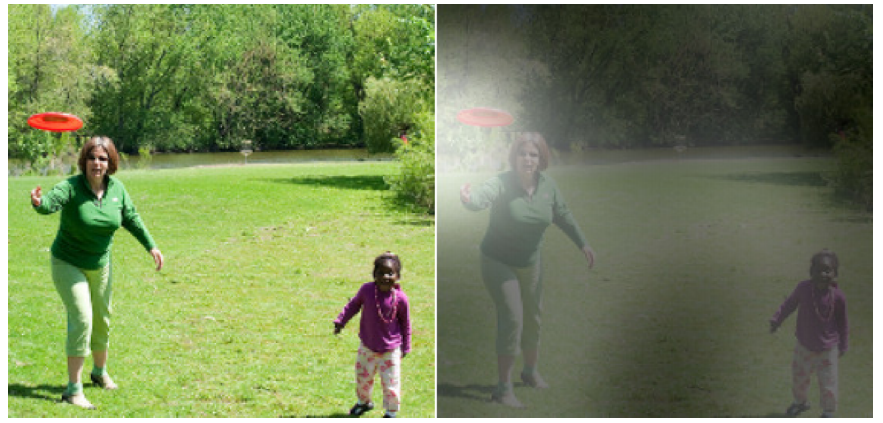

**可解释性（Explainability）**：注意力机制的一个额外好处是，它们更容易理解是什么导致模型产生其输出。这叫做可解释性。当模型犯了错误时，它会特别有用：例如，如果一只狗在雪地上行走的图像被标记为“在雪地里行走的狼”，那么你可以回去检查模型在输出“狼”这个词时关注的是什么。你可能会发现，它不仅关注狗，也关注雪，暗示了一个可能的解释：也许模型学会区分狗和狼的方法是通过检查周围是否有很多雪。然后你可以通过训练更多没有雪的狼和有雪的狗的图像的模型来解决这个问题。这个例子来自 Marco Tulio Ribeiro 等人 2016 年的一篇伟大论文，该论文使用了一种不同的方法来解释：围绕分类器的预测局部学习可解释模型。在某些应用程序中，可解释性不仅仅是一个调试模型的工具；它可以是一个法律要求——想想一个系统来决定它是否应该给你一笔贷款。

当 transformer 在2017年问世时，人们开始在 NLP 之外试验它们，它们首先与 CNN 一起使用，而没有取代它们。相反，transformer 通常被用来取代 RNN ，例如，在图像字幕模型中。在 Facebook 研究人员 2020 年的一篇论文中，transformer 变得更加视觉化，该论文提出了一种用于目标检测的混合 CNN-transformer 架构。同样，CNN 首先处理输入图像并输出一组 feature map，然后这些 feature map 被转换为序列并输入一个 transformer ，transformer 输出边界框预测。但是，大部分的视觉工作仍然是由 CNN 完成的。

然后，在 2020 年 10 月，一组谷歌研究人员发布了一篇论文，其中介绍了一种完全基于 transformer 的视觉模型，称为 **vision transformer（ViT）** 。这个想法非常简单：只需将图像切成 16×16 的小方块，然后将方块序列视为单词表示序列。更准确地说，这些正方形首先被展平为 16×16×3=768 维向量——3 维用于 RGB 颜色通道——然后这些向量经过一个线性层，该层对其进行变换但保持其维度。然后可以像处理单词嵌入序列一样处理生成的向量序列：这意味着添加位置嵌入，并将结果传递给 transformer 。就是这样！该模型在 ImageNet 图像分类方面击败了最先进的技术，但为了公平起见，作者不得不使用超过 3 亿张额外的图像进行训练。这是有道理的，因为 transformer 没有像卷积神经网络那样多的归纳偏差，所以它们需要额外的数据来学习 CNN 隐式假设的东西。

**注意**：归纳偏差是指该模型由于其体系结构而做出的一种隐式假设。例如，线性模型隐式地假设数据是线性的。CNN 含蓄地假设，在一个位置学习到的模式可能在其他位置也有用。RNN 隐式地假设输入是有序的，并且最近的 token 比旧的 token 更重要。假设模型是正确的，其归纳偏差越大，模型需要的训练数据就越少。但是，如果隐式假设是错误的，那么模型即使在大数据集上训练也可能会表现不佳。

仅仅两个月后，Facebook 的一个研究团队发布了一篇论文，介绍了 **data-efficient image transformers（DeiTs）**。他们的模型在 ImageNet 上取得了有竞争力的结果，而不需要任何额外的训练数据。该模型的架构实际上与最初的 ViT 相同，但作者使用了一种提炼技术，将知识从最先进的 CNN 模型转移到他们的模型中。

然后，在 2021 年 3 月，DeepMind 发布了一篇重要论文，介绍了 **Perceiver** 架构。它是一种 **多模态（multimodal）** transformer ，这意味着您可以为其提供文本、图像、音频或几乎任何其他模态。在此之前，由于注意力层的性能和 RAM 瓶颈，Transformers 一直被限制在相当短的序列中。这排除了音频或视频等模式，并迫使研究人员将图像视为块序列，而不是像素序列。瓶颈是由于自注意力，其中每个 token 都必须关注其他每个 token ：如果输入序列有 $M$ 个 token ，则注意力层必须计算一个 $M×M$ 矩阵，如果 $M$ 非常大，该矩阵可能会很大。感知器通过逐渐改进输入的相当短的 **潜在表示（latent representation）** 来解决这个问题，该表示由 $N$ 个 token 组成——通常只有几百个。（潜在这个词的意思是隐藏的或内部的）该模型仅使用交叉注意力层，将潜在表示作为查询提供给它们，并将（可能很大的）输入作为值。这只需要计算一个 $M×N$ 矩阵，因此计算复杂度关于 $M$ 是线性的，而不是二次的。在经过几个交叉注意力层之后，如果一切顺利，潜在表示最终会捕获输入中重要的所有内容。作者还建议在连续的交叉注意力层之间共享权重：如果你这样做，那么感知器实际上变成了一个 RNN。事实上，共享的交叉注意力层可以看作是不同 time step 的同一个记忆单元，而潜在表示对应于单元的上下文向量。在每个 time step，相同的输入被重复地馈送到记忆单元。看起来 RNN 并没有完全死！

仅仅一个月后，Mathilde Caron 等人介绍了 DINO，这是一种令人印象深刻的视觉转换器，完全没有标签训练，使用自监督，并且能够进行高精度语义分割。该模型在训练期间被复制，一个网络充当老师，另一个网络充当学生。梯度下降只影响学生，而教师的权重只是学生权重的指数移动平均值。学生被训练来匹配老师的预测：因为他们几乎是同一个模型，这被称为 **自我提炼（self-distillation）**。在每个训练步骤中，教师和学生以不同的方式增强输入图像，因此他们看不到完全相同的图像，但他们的预测必须匹配。这迫使他们提出高级表示。为了防止 **模式崩溃（mode collapse）**，学生和老师总是输出相同的东西，完全忽略输入，DINO 跟踪老师输出的移动平均值，并调整老师的预测以确保它们保持平均以零为中心。DINO 还迫使老师对其预测具有高度的信心：这称为 **锐化（sharpening）**。这些技术共同保留了教师输出的多样性。

在 2021 年的一篇论文中，谷歌研究人员展示了如何根据数据量扩大或缩小 ViT。他们设法创建了一个庞大的 20 亿参数模型，在 ImageNet 上达到了超过 90.4% 的 top-1 准确率。相反，他们还训练了一个按比例缩小的模型，在 ImageNet 上达到了超过 84.8% 的 top-1 准确率，仅使用 10,000 张图像：每个类只有 10 张图像！

直到今天，Vision Transformer 的进步仍在稳步推进。例如，2022 年 3 月，Mitchell Wortsman 等人发表的一篇论文证明了可以首先训练多个 transformer ，然后平均它们的权重以创建一个新的和改进的模型。这类似于集成（见第 7 章），除了最后只有一个模型，这意味着没有推理时间惩罚。

Transformer 的最新趋势在于构建大型多模态模型，通常能够进行零样本或少样本学习。例如，OpenAI 的 2021 CLIP 论文提出了一个经过预训练以将字幕与图像匹配的大型 transformer 模型：该任务使其能够学习出色的图像表示，然后该模型可以直接用于图像分类等任务，使用简单的文本提示，例如“ a photo of a cat”。不久之后，OpenAI 宣布了 DALL·E ，能够根据文本提示生成令人惊叹的图像。DALL·E 2 ，使用扩散模型生成更高质量的图像（参见第 17 章）。

2022 年 4 月，DeepMind 发布了 Flamingo 论文，其中介绍了一系列模型，这些模型在多模态（包括文本、图像和视频）的各种任务上进行了预训练。单个模型可以用于非常不同的任务，例如问答、图像字幕等。不久之后，在 2022 年 5 月，DeepMind 推出了 GATO，这是一种多模态模型，可以用作强化学习代理的策略（RL 将在第 18 章中介绍）。同一个 transformer 可以与你聊天、为图片添加字幕、玩 Atari 游戏、控制（模拟）机械臂等等，所有这些都“只有”12 亿个参数。冒险还在继续！

**注意**：这些惊人的进步导致一些研究人员声称人类水平的人工智能已经接近，“**scale is all you need**”，并且其中一些模型可能“具有轻微的意识”。其他人指出，尽管取得了惊人的进步，但这些模型仍然缺乏人类智能的可靠性和适应性、我们进行符号推理的能力、基于单个示例进行概括的能力等等。

正如你所看到的，transformer 无处不在！好消息是，你的通常不必自己实现 transformer ，因为许多优秀的预训练模型很容易通过 TensorFlow Hub 或 Hugging Face 的 model hub下载。您已经看到了如何使用来自 TF Hub 的模型，所以让我们通过快速浏览一下 Hugging Face 的生态系统来结束这一章。

## 7. Hugging Face 的 Transformer 库（Hugging Face’s Transformers Library）

今天谈论 Transformer 就不能不提到 Hugging Face，这是一家 AI 公司，它为 NLP、视觉等构建了一个完整的易于使用的开源工具生态系统。他们生态系统的核心组成部分是 Transformers 库，它允许您轻松下载预训练模型，包括其相应的分词器，然后根据需要在您自己的数据集上对其进行微调。此外，该库支持 TensorFlow、PyTorch 和 JAX（使用 Flax 库）。

使用 Transformers 库的最简单方法是使用 **transformers.pipeline()** 函数：你只需指定你想要的任务，比如情绪分析，它就会下载一个默认的预训练模型，随时可以使用——真的再简单不过了：

In [49]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")  # many other tasks are available
result = classifier("The actors were very convincing.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


C:\ProgramData\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tu'tu\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_21']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


结果是一个 Python 列表，每个输入文本包含一个字典：

In [50]:
result

[{'label': 'POSITIVE', 'score': 0.9998071789741516}]

在这个例子中，模型正确地发现这个句子是积极的，置信度约为 99.98% 。当然，您也可以将一批句子传递给模型：

In [51]:
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

**偏见与公平（Bias and Fairness）**：

正如输出所示，这个特定的分类器喜欢印度人，但对伊拉克人有严重的偏见。您可以在自己的国家或城市试用此代码。这种不良偏差通常在很大程度上来自训练数据本身：在这种情况下，训练数据中有大量与伊拉克战争相关的负面句子。这种偏差随后在微调过程中被放大，因为模型被迫在两个类别之间进行选择：正面或负面。如果你在微调时添加一个中性类，那么国家偏见就会基本消失。但训练数据并不是偏差的唯一来源：模型的架构、用于训练的损失或正则化类型、优化器；所有这些都会影响模型最终学习的内容。即使是几乎没有偏见的模型也可以以有偏见的方式使用，就像调查问题可能有偏见一样。

了解 AI 中的偏见并减轻其负面影响仍然是一个活跃的研究领域，但有一点是肯定的：在急于将模型部署到生产环境之前，您应该停下来思考一下。问问你自己，这个模型会如何造成伤害，即使是间接的。例如，如果模型的预测被用来决定是否给某人一笔贷款，那么这个过程应该是公平的。因此，确保您不仅在整个测试集上评估模型的平均性能，而且在各个子集上评估模型：例如，您可能会发现，尽管模型平均工作得很好，但对于某些类别的人，它的性能非常糟糕。您可能还想运行反事实测试：例如，当您只需切换某人的性别时，您可能想检查模型的预测是否不会改变。

如果这个模型平均运行得很好，那么就很容易把它推向生产阶段，然后转向其他东西，特别是如果它只是一个更大的系统的一个组成部分。但一般来说，如果你不解决这些问题，就没有人会解决，而你的模型最终可能会弊大于利。解决方案取决于这个问题：它可能需要重新平衡数据集，对不同的数据集进行微调，切换到另一个预训练模型，调整模型的架构或超参数，等等。

**pipeline()** 函数使用给定任务的默认模型。例如，对于情感分析等文本分类任务，在撰写本文时，它默认为 **distilbert-base-uncased-finetuned-sst-2-english** ,这是一个带有无分类分词器的 **DistilBERT** 模型，在英语维基百科和英文书籍语料库上训练，并在 **Stanford Sentiment Treebank v2（SST 2）** 任务上进行微调。也可以手动指定不同的模型。例如，您可以使用针对 **多类型自然语言推理（Multi-Genre Natural Language Inference，MultiNLI）** 任务微调的 **DistilBERT** 模型，该模型将两个句子分为三类：矛盾、中性或蕴含。方法如下：

In [60]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

Some layers from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli and are newly initialized: ['dropout_41']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'contradiction', 'score': 0.9790192246437073}]

**注意**：您可以在 https://huggingface.co/models 找到可用的模型，在 https://huggingface.co/tasks 找到任务列表。

pipeline API 非常简单和方便，但有时您将需要更多的控制。对于这种情况，Transformers 库提供了许多类，包括各种类型的分词器、模型、配置、回调等等。例如，让我们使用 **TFAutoModelForSequenceClassification** 和 **AutoTokenizer** 类加载相同的 **DistilBERT** 模型及其相应的分词器：

In [62]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

Some layers from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli and are newly initialized: ['dropout_61']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


接下来，让我们标记几对句子。在这段代码中，我们激活填充并指定我们想要 TensorFlow 张量而不是 Python 列表：

In [63]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]])>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])>}

**注意**：您可以不必将 "Sentence 1 \[SEP\] Sentence 2" 传递给分词器，而是传递给其一个元组：("Sentence 1", "Sentence 2") 。

In [64]:
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),
                       ("Joe lived for a very long time.", "Joe is old.")],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]])>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])>}

输出是 **BatchEncoding** 类的一个类似字典的实例，它包含 token ID 的序列，以及一个为填充 token 包含 0 的掩码：

如果在调用分词器时设置 **return_token_type_ids=True**，您还将得到一个额外的张量，指示每个 token 属于哪个句子。这是一些模型所需要的，但不是 **DistilBERT** 。

接下来，我们可以直接将这个 **BatchEncoding** 对象传递给模型；它返回一个包含其预测的类对数的 **TFSequenceClassifierOutput** 对象：

In [65]:
outputs = model(token_ids)

outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1103628,  1.1788132,  1.4077797],
       [-0.0138243,  1.0967412, -0.9933757]], dtype=float32)>, hidden_states=None, attentions=None)

最后，我们可以应用 **softmax** 激活函数将这些对数转换为类概率，并使用 **argmax()** 函数来预测每个输入句子对的概率最高的类：

In [66]:
Y_probas = tf.keras.activations.softmax(outputs.logits)

Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01624894, 0.43580878, 0.54794234],
       [0.22667746, 0.6882098 , 0.08511274]], dtype=float32)>

In [67]:
Y_pred = tf.argmax(Y_probas, axis=1)

Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1], dtype=int64)>

在这个例子中，模型正确地将第一句归为中性（我喜欢足球并不意味着其他人都喜欢），第二句归为蕴含（乔确实很老了）。

如果您希望在自己的数据集上微调这个模型，您可以像往常一样用 Keras 来训练模型，因为它只是一个常规的 Keras 模型，带有一些额外的方法。但是，由于模型输出对数而不是概率，所以您必须使用 **tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)** 损失，而不是通常的 **"sparse_categorical_crossentropy"** 损失。此外，该模型不支持在训练期间的 **BatchEncoding** 输入，所以您必须使用它的 **data** 属性来获得一个常规的字典：

In [ ]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]

X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2


Hugging Face 还构建了一个数据集库，您可以使用它来轻松地下载标准数据集（如 IMDb ）或自定义数据集，并使用它来对模型进行微调。它类似于 TensorFlow Dataset，但它也提供了在动态执行常见的预处理任务的工具，比如掩码。数据集的列表可以在 https://huggingface.co/datasets 上找到。

这应该会让你开始 Hugging Face 的生态系统。要了解更多信息，您可以前往 https://huggingface.co/docs 获取文档，其中包括许多教程笔记、视频、完整的 API 等等。我还建议你看看 O'Reilly 的书 Natural Language Processing with Transformers: Building Language Applications with Hugging Face 。

在下一章中，我们将讨论如何使用自动编码器以非监督的方式学习深度表示，并且我们将使用生成式对抗网络来产生图像和更多！